#### Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast   # abstract syntax trees

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder,  MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler
import joblib

#### Import Datasets


In [2]:
all_df= pd.read_csv('../datasets/synthetic_fraud_data.csv',)

In [3]:
all_df.shape

(7483766, 24)

In [4]:
# df= all_df.sample(frac=0.1, random_state=42)
df= all_df.sample(frac=0.3, random_state=42)
df.shape

(2245130, 24)

In [5]:
df.head()

,transaction_id,customer_id,card_number,timestamp,merchant_category,merchant_type,merchant,amount,currency,country,...,device,channel,device_fingerprint,ip_address,distance_from_home,high_risk_merchant,transaction_hour,weekend_transaction,velocity_last_hour,is_fraud
543612,TX_8ab03451,CUST_45506,4276387718511132,2024-10-02 07:37:53.648473+00:00,Restaurant,casual,Red Lobster,544.43,BRL,Brazil,...,Firefox,web,3e8902e5ca8ea02f5c1cafab83b7855c,236.8.107.158,0,False,7,False,"{'num_transactions': 410, 'total_amount': 9771...",False
1940295,TX_9b278186,CUST_60434,6372131493335111,2024-10-08 01:20:04.635733+00:00,Education,online,Skillshare,1.46,CAD,Canada,...,Magnetic Stripe,pos,1703fbd0ec57fee12ffe2257dc15e3f2,119.123.124.179,1,False,1,False,"{'num_transactions': 1203, 'total_amount': 314...",True
6913787,TX_7f80b3c4,CUST_47739,6032951922681435,2024-10-28 16:04:39.625391+00:00,Entertainment,streaming,Disney+,158.73,CAD,Canada,...,Chip Reader,pos,3481722c89ab59b5ea450adfc07b55ba,105.166.250.133,0,True,16,False,"{'num_transactions': 100, 'total_amount': 3168...",True
869785,TX_7202f8a2,CUST_77691,5021869140628407,2024-10-03 15:06:36.624159+00:00,Restaurant,casual,TGI Fridays,1074.57,BRL,Brazil,...,Firefox,web,f5b0c8568cbb2c110ac396ff09baad90,196.70.93.112,0,False,15,False,"{'num_transactions': 335, 'total_amount': 6421...",False
4680413,TX_75f107d6,CUST_86097,5070103713053862,2024-10-19 10:30:45.169341+00:00,Entertainment,streaming,HBO Max,1399.64,MXN,Mexico,...,Firefox,web,c2515c6f7a3b534c8ab23d31cf57f29a,161.127.213.117,0,True,10,True,"{'num_transactions': 426, 'total_amount': 1433...",False


##### parse timestamp

In [6]:
df.timestamp= pd.to_datetime(df['timestamp'], format= 'ISO8601')

In [7]:
def modify_timestamp():
    df['year']= df.timestamp.dt.year
    df['month']= df.timestamp.dt.month
    df['day']= df.timestamp.dt.day    
    df['hour']= df.timestamp.dt.hour  # transaction_hour column already in dataset
    df['minute']= df.timestamp.dt.minute
    
    # drop timestamp as well as transaction_hour column
    df.drop(['timestamp','transaction_hour'], axis=1, inplace=True)

modify_timestamp()

#### Feature Engineering

##### extract velocity_last_hour
velocity_last_hour column is in str format of dictionary
- At first convert it into dictonary 
- extracting features 
- join with original dataframe and drop velocity_last_hour

all this is done using `ast (Abstract Syntax Trees)`

<pre>
import ast
ast_df= df.velocity_last_hour.apply(ast.literal_eval)  # converted string into ast trees format 
ast_df= ast_df.apply(pd.Series)  # converted into dataframe
df= df.drop(columns='velocity_last_hour').join(ast_df)  # joined with original df with velocity_last_hour dropped
df.head()
</pre>

- .apply(pd.Series) `(slower)` 
    - Row-wise operation
    - creates new DataFrame (increase memory usage & processing time)
- .to_list() `faster`
    - Batch Processing
    - creates ne python list (more light weight & faster to handle)

In [8]:
# extract without creating extra variables (preseve memory)
# df= df.drop(columns='velocity_last_hour').join(df.velocity_last_hour.apply(ast.literal_eval).apply(pd.Series)) (slower)

df= df.drop(columns= 'velocity_last_hour').join(
    pd.DataFrame(df.velocity_last_hour.apply(ast.literal_eval).to_list(), index = df.index))

##### save dataframe for faster acess

In [9]:
df.to_csv('extracted_df.csv')

In [10]:
df= pd.read_csv('extracted_df.csv', index_col= 0)
df.head(3)

,transaction_id,customer_id,card_number,merchant_category,merchant_type,merchant,amount,currency,country,city,...,year,month,day,hour,minute,num_transactions,total_amount,unique_merchants,unique_countries,max_single_amount
543612,TX_8ab03451,CUST_45506,4276387718511132,Restaurant,casual,Red Lobster,544.43,BRL,Brazil,Unknown City,...,2024,10,2,7,37,410,9.771835e+06,103,12,2.076391e+06
1940295,TX_9b278186,CUST_60434,6372131493335111,Education,online,Skillshare,1.46,CAD,Canada,Unknown City,...,2024,10,8,1,20,1203,3.149272e+07,105,12,2.426354e+06
6913787,TX_7f80b3c4,CUST_47739,6032951922681435,Entertainment,streaming,Disney+,158.73,CAD,Canada,Unknown City,...,2024,10,28,16,4,100,3.168371e+06,62,11,8.079625e+05


In [11]:
df.isna().sum().sum()

0

In [12]:
df.duplicated().sum().sum()

0

df is good as it  has no missing and duplicted values. 

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2245130 entries, 543612 to 3436679
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   transaction_id       object 
 1   customer_id          object 
 2   card_number          int64  
 3   merchant_category    object 
 4   merchant_type        object 
 5   merchant             object 
 6   amount               float64
 7   currency             object 
 8   country              object 
 9   city                 object 
 10  city_size            object 
 11  card_type            object 
 12  card_present         bool   
 13  device               object 
 14  channel              object 
 15  device_fingerprint   object 
 16  ip_address           object 
 17  distance_from_home   int64  
 18  high_risk_merchant   bool   
 19  weekend_transaction  bool   
 20  is_fraud             bool   
 21  year                 int64  
 22  month                int64  
 23  day                  int64  
 24

In [14]:
df.columns

Index(['transaction_id', 'customer_id', 'card_number', 'merchant_category',
       'merchant_type', 'merchant', 'amount', 'currency', 'country', 'city',
       'city_size', 'card_type', 'card_present', 'device', 'channel',
       'device_fingerprint', 'ip_address', 'distance_from_home',
       'high_risk_merchant', 'weekend_transaction', 'is_fraud', 'year',
       'month', 'day', 'hour', 'minute', 'num_transactions', 'total_amount',
       'unique_merchants', 'unique_countries', 'max_single_amount'],
      dtype='object')

In [15]:
df.head(2)

,transaction_id,customer_id,card_number,merchant_category,merchant_type,merchant,amount,currency,country,city,...,year,month,day,hour,minute,num_transactions,total_amount,unique_merchants,unique_countries,max_single_amount
543612,TX_8ab03451,CUST_45506,4276387718511132,Restaurant,casual,Red Lobster,544.43,BRL,Brazil,Unknown City,...,2024,10,2,7,37,410,9.771835e+06,103,12,2.076391e+06
1940295,TX_9b278186,CUST_60434,6372131493335111,Education,online,Skillshare,1.46,CAD,Canada,Unknown City,...,2024,10,8,1,20,1203,3.149272e+07,105,12,2.426354e+06


#### features and label

In [16]:
col_to_drop= ['transaction_id', 'customer_id', 'card_number', 'ip_address', 'device_fingerprint' ]
one_enc= ['merchant_category', 'card_type', 'device', 'channel']
ord_enc= ['city_size']
freq_enc=  ['merchant_type', 'merchant', 'country','city'] # not to put currency later converted to usd
binary_enc= ['distance_from_home', 'card_present', 'high_risk_merchant', 'weekend_transaction', 'is_fraud']

time_cols= ['year', 'month', 'day', 'hour', 'minute']
outlier_check= ['num_transactions', 'total_amount', 'unique_merchants', 'unique_countries', 'max_single_amount']

In [17]:
# encode all boolean columns as 0,1
df[binary_enc]= df[binary_enc].astype('int')

# drop unnecessary columns
df.drop(col_to_drop, axis=1, inplace=True)

X= df.drop('is_fraud', axis=1)
y= df.is_fraud

##### visualize datasets

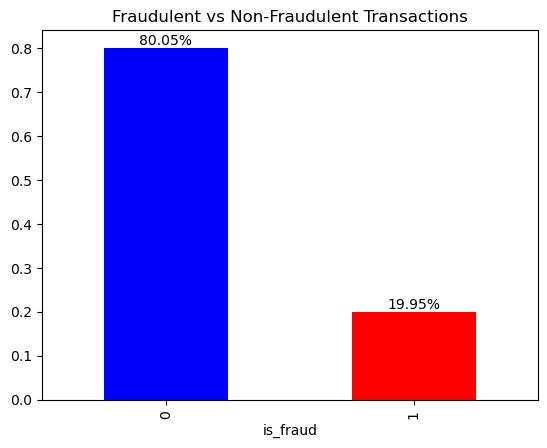

In [18]:
df.is_fraud.value_counts(normalize=True).plot.bar(title='Fraudulent vs Non-Fraudulent Transactions', color=['blue', 'red'])
for index, value in enumerate(df.is_fraud.value_counts(normalize=True)):
    plt.text(index, value, f'{value:.2%}', ha='center', va='bottom')
plt.show()

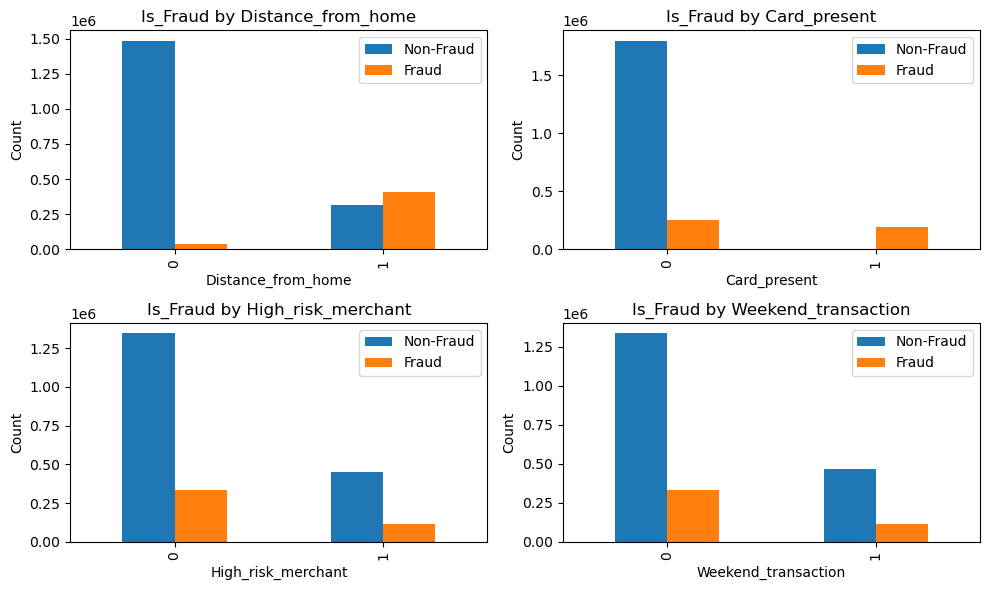

In [19]:
rows = 2
cols = -(-len(binary_enc[:-1]) // rows)  # Calculate the number of columns needed

fig, axes = plt.subplots(rows, cols, figsize=(10, 6))
axes = axes.flatten()  # Flatten the axes array for easier indexing

for i, col in enumerate(binary_enc[:-1]):
    df.groupby([col, 'is_fraud']).size().unstack().plot(
        kind='bar',
        ax=axes[i],
        title=f'Is_Fraud by {col.capitalize()}'
    )
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel('Count')
    axes[i].legend(['Non-Fraud', 'Fraud'])

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

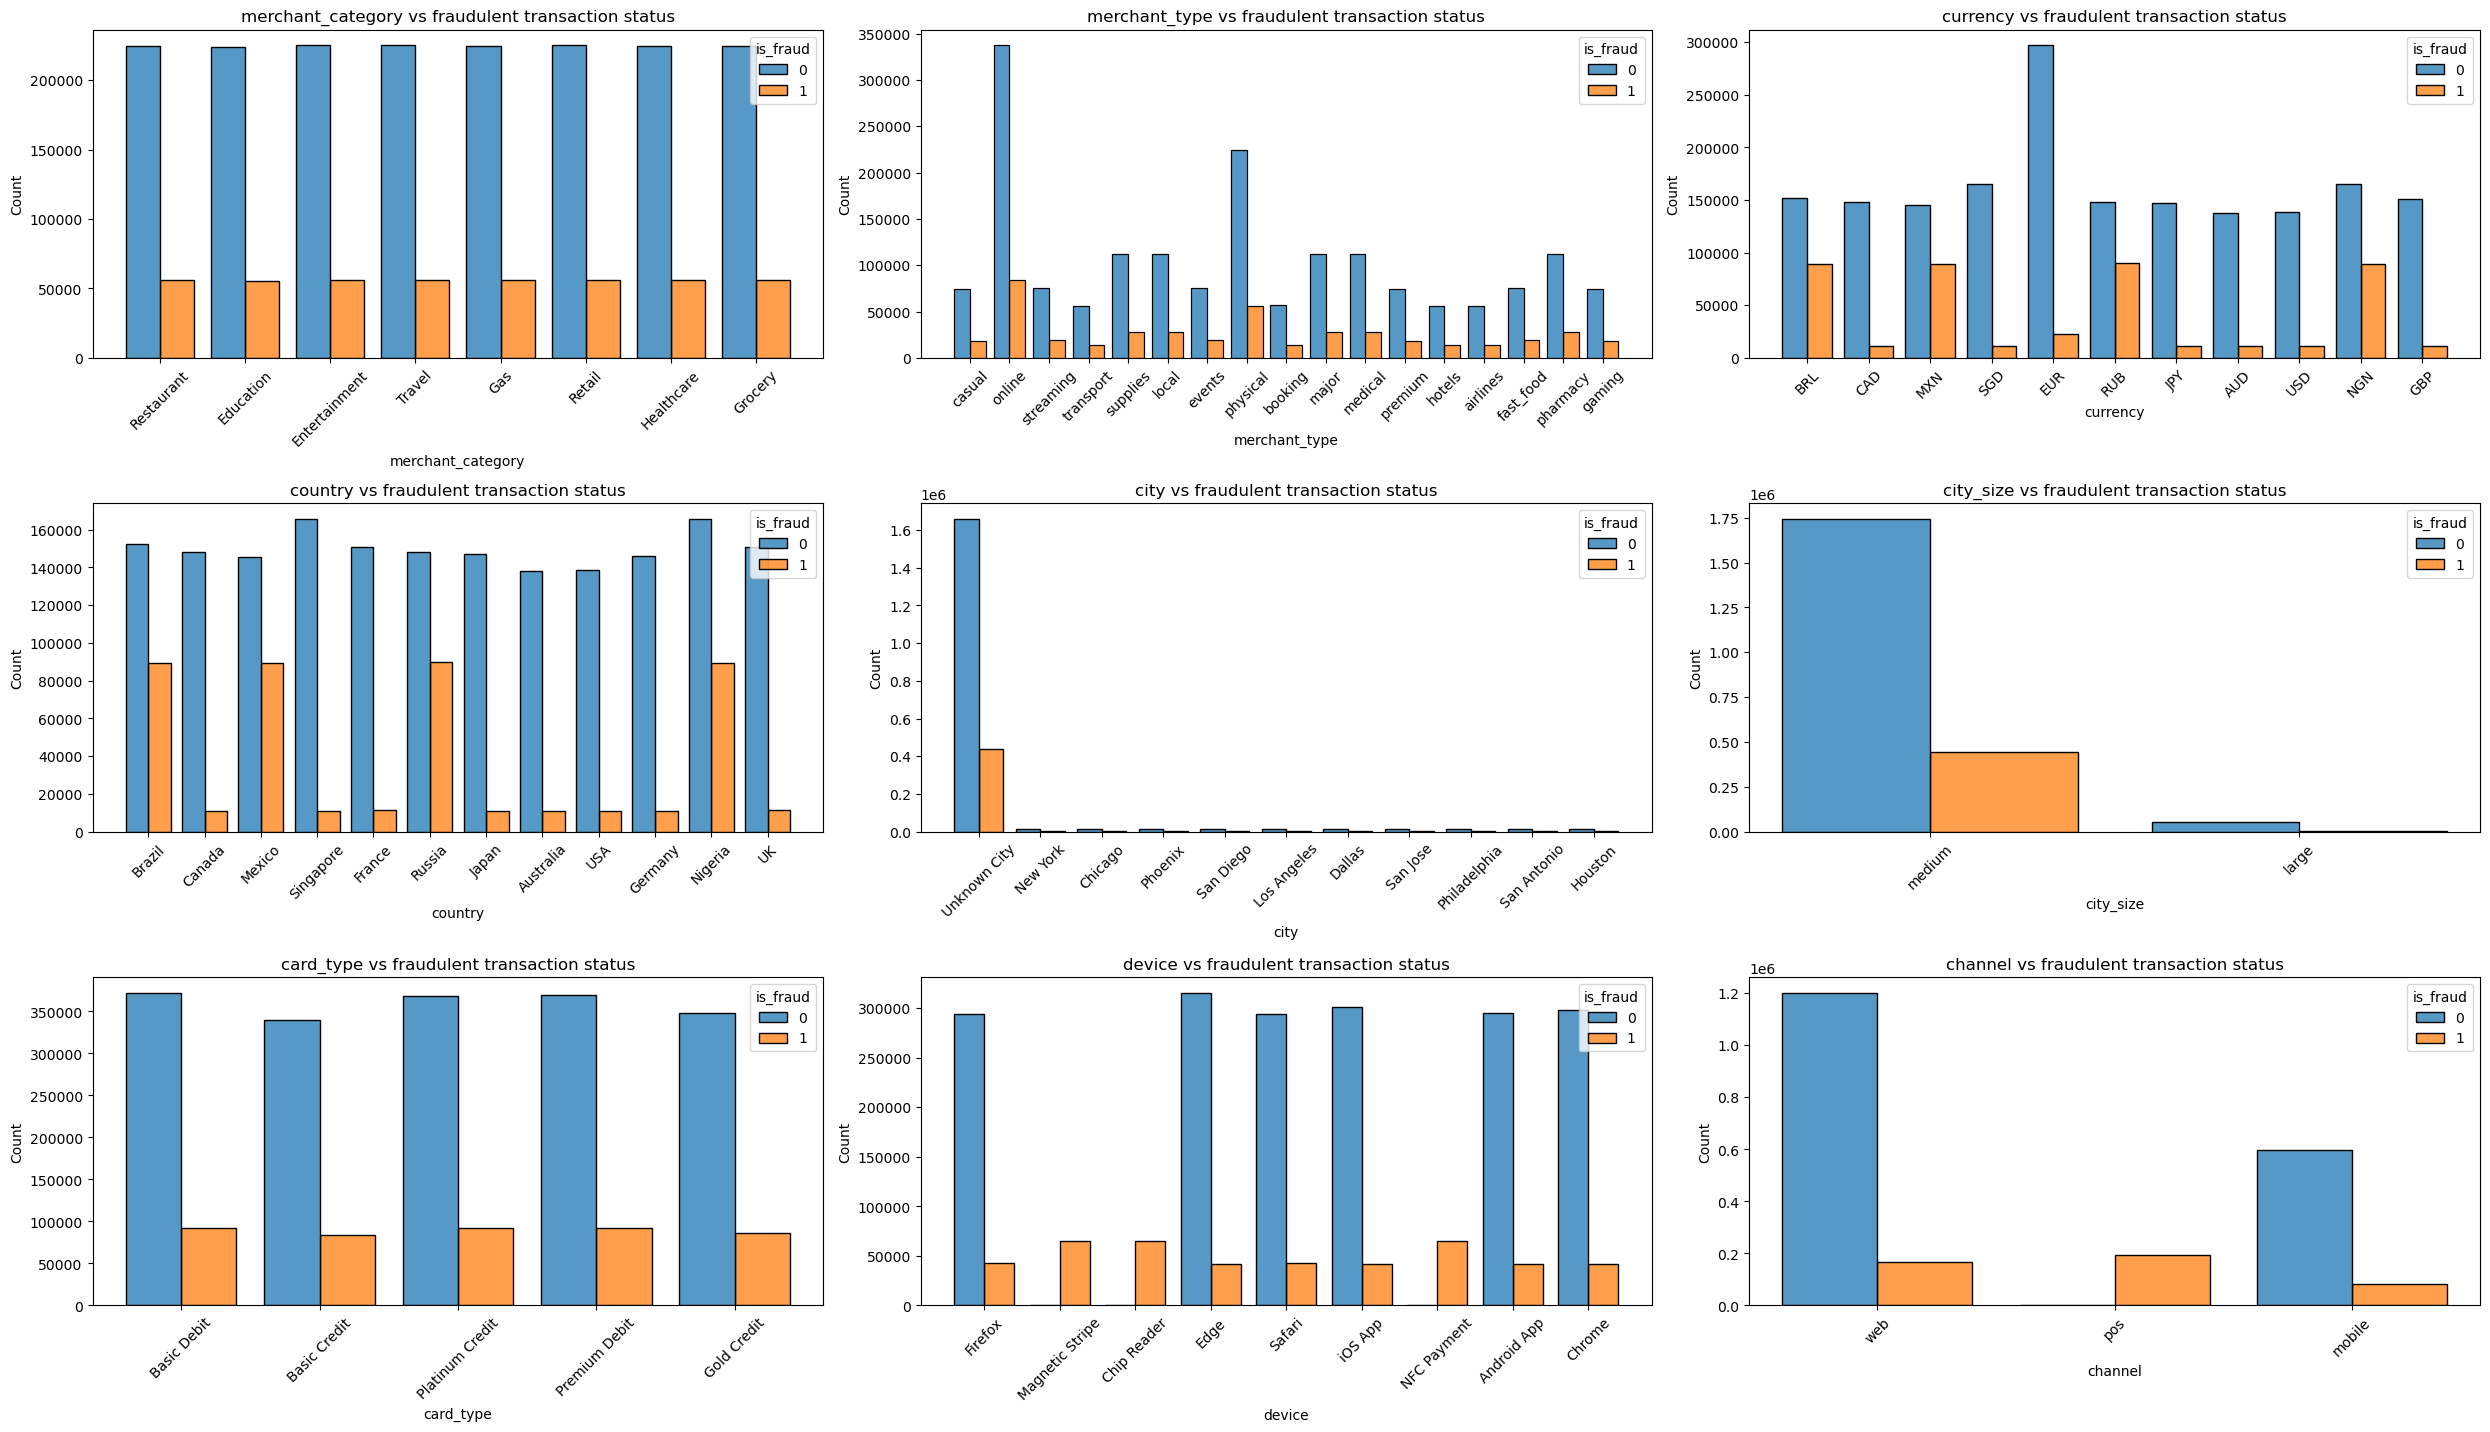

In [20]:
## Get the name of entire categorical features
categorical_cols = list(df.select_dtypes('object').columns)
categorical_cols.remove('merchant')
categorical_cols


# Adjust the number of rows and columns for subplots
ncol = 3
nrow = len(categorical_cols) // ncol + 1

fig, axes = plt.subplots(nrow, ncol, figsize=(25, 18))
axes = axes.flatten()  # Flatten axes for easier indexing

for i, col in enumerate(categorical_cols):
    sns.histplot(data=df, x=col, hue = 'is_fraud', multiple = 'dodge', shrink = 0.8, ax=axes[i])
    axes[i].set_title(f'{col} vs fraudulent transaction status')
    axes[i].tick_params(axis = 'x', rotation = 45)
    
# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

##### currency conversion

The current transaction amount is represented in its own local currency in which new feature should be generated using the standard USD

In [21]:
X.currency.unique()

array(['BRL', 'CAD', 'MXN', 'SGD', 'EUR', 'RUB', 'JPY', 'AUD', 'USD',
       'NGN', 'GBP'], dtype=object)

In [22]:
def convert_currency_amt(df):
    conversion_rates= {
        'EUR': 1.06,
        'CAD': 0.72,
        'RUB': 0.01,
        'NGN': 0.0006,
        'SGD': 0.75,
        'MXN': 0.049,
        'BRL': 0.17,
        'AUD': 0.65,
        'JPY': 0.0065
    }
    # Add a column by mapping the currency to the corresponding conversion rate,
    # defaulting to 1.28 for Great Britain Pound if currency is not in the dictionary
    df['USD_converted_amt']= df.amount * df.currency.map(conversion_rates).fillna(1.28)
    df.drop(['currency', 'amount'], axis=1, inplace= True)

    return df

X= convert_currency_amt(X)

In [23]:
outlier_check.append('USD_converted_amt')

#### train test split

In [24]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, random_state=42)

In [25]:
X_train[:2]

,merchant_category,merchant_type,merchant,country,city,city_size,card_type,card_present,device,channel,...,month,day,hour,minute,num_transactions,total_amount,unique_merchants,unique_countries,max_single_amount,USD_converted_amt
234181,Retail,online,AliExpress,Germany,Unknown City,medium,Basic Debit,0,Android App,mobile,...,9,30,23,16,3486,8.615629e+07,105,12,988918.795670,417.3750
6315225,Healthcare,medical,Urgent Care,Singapore,Unknown City,medium,Basic Credit,0,Safari,web,...,10,26,4,38,67,4.075023e+05,48,10,217975.132575,300.7575


#### frequency encoding

In [26]:
# frequency encoding
all_freq_map= {}
for col in freq_enc:
    freq_map= X_train[col].value_counts().to_dict()
    all_freq_map[col]= freq_map     # save to all_freq_map  and dump later 
    X_train[col]= X_train[col].map(freq_map)
    
    # replace Nan with minimum value (for unseen data)    
    X_test[col]= X_test[col].map(freq_map).fillna(min(freq_map.values()))    

In [27]:
X_train[:2]

,merchant_category,merchant_type,merchant,country,city,city_size,card_type,card_present,device,channel,...,month,day,hour,minute,num_transactions,total_amount,unique_merchants,unique_countries,max_single_amount,USD_converted_amt
234181,Retail,336902,16135,126057,1676288,medium,Basic Debit,0,Android App,mobile,...,9,30,23,16,3486,8.615629e+07,105,12,988918.795670,417.3750
6315225,Healthcare,112271,28218,141478,1676288,medium,Basic Credit,0,Safari,web,...,10,26,4,38,67,4.075023e+05,48,10,217975.132575,300.7575


#### visualize datasets

In [28]:
pd.options.display.float_format= "{:.2f}".format
X_train.describe()

,merchant_type,merchant,country,city,card_present,distance_from_home,high_risk_merchant,weekend_transaction,year,month,day,hour,minute,num_transactions,total_amount,unique_merchants,unique_countries,max_single_amount,USD_converted_amt
count,1796104.00,1796104.00,1796104.00,1796104.00,1796104.00,1796104.00,1796104.00,1796104.00,1796104.00,1796104.00,1796104.00,1796104.00,1796104.00,1796104.00,1796104.00,1796104.00,1796104.00,1796104.00,1796104.00
mean,151924.58,20262.23,156543.36,1565264.13,0.09,0.32,0.25,0.26,2024.00,9.97,15.96,12.15,29.51,409.25,19946055.91,80.04,10.66,1725602.21,538.18
std,100976.54,8659.57,33583.03,415272.72,0.28,0.47,0.43,0.44,0.00,0.18,8.89,6.54,17.32,391.45,35720354.19,30.46,2.62,1397090.99,718.99
min,55794.00,9215.00,119377.00,11810.00,0.00,0.00,0.00,0.00,2024.00,9.00,1.00,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00
25%,74804.00,14153.00,126281.00,1676288.00,0.00,0.00,0.00,0.00,2024.00,10.00,8.00,7.00,15.00,106.00,3374442.94,64.00,11.00,801677.94,166.35
50%,111930.00,16169.00,141478.00,1676288.00,0.00,0.00,0.00,0.00,2024.00,10.00,16.00,12.00,30.00,292.00,10169199.00,95.00,12.00,1234099.86,353.85
75%,224166.00,27978.00,190646.00,1676288.00,0.00,1.00,1.00,1.00,2024.00,10.00,24.00,18.00,45.00,606.00,22740566.27,104.00,12.00,2290390.07,619.98
max,336902.00,37522.00,204227.00,1676288.00,1.00,1.00,1.00,1.00,2024.00,10.00,30.00,23.00,59.00,3854.00,1046461946.34,105.00,12.00,6253152.62,18277.24


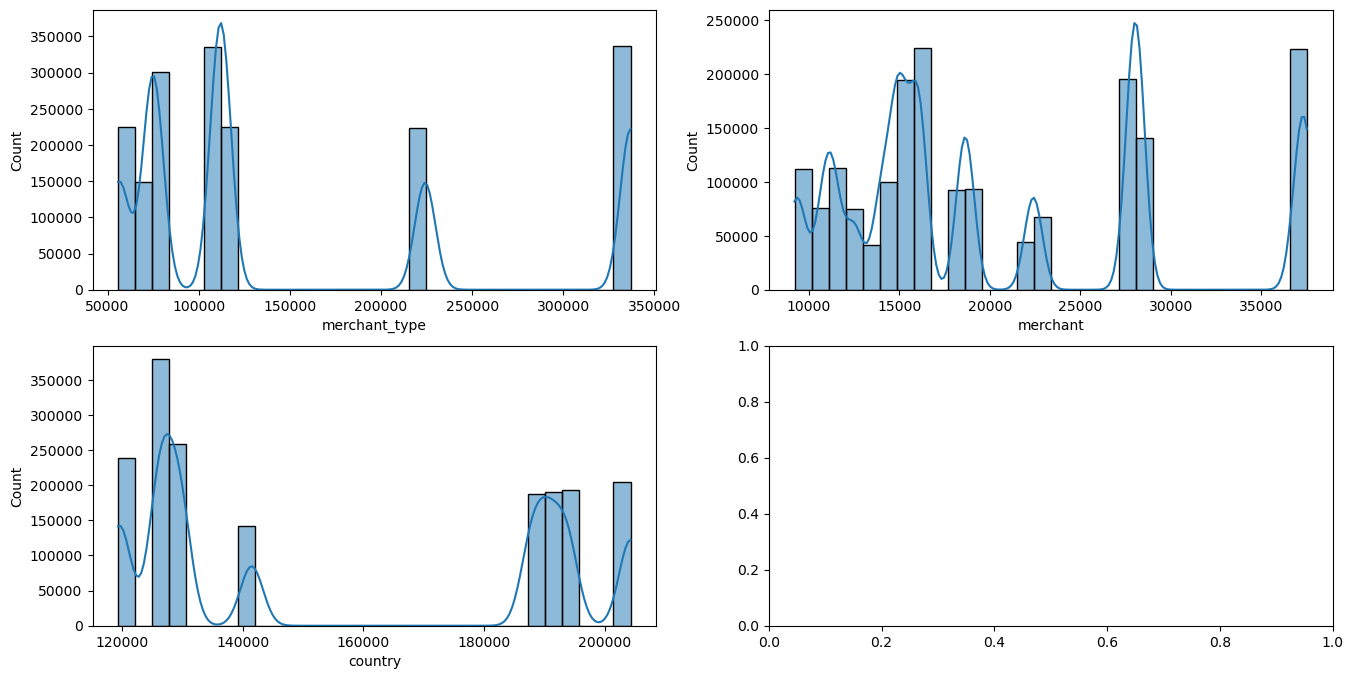

In [29]:
rows= 2
cols= -(- len(freq_enc) // rows) #  -(-7/3) == 3 fl0or lower to -3 then make it 3

fig, axes = plt.subplots(rows, cols, figsize=(16, 8))  # 1 row, 2 columns

for i in range(rows):
    for j in range(cols):
        if (i+1) * (j+1) < len(freq_enc):
            col= freq_enc[i * cols + j]
            sns.histplot(X_train[col], kde=True, bins=30, ax= axes[i][j])
            # axes[i][j].set_title(f"Distribution of {col}")


#### analysis dataset

In [30]:
df.groupby(['merchant_category', 'merchant_type'])[['merchant']].nunique()

merchant
merchant_category merchant_type          
Education         online                5
                  supplies              3
Entertainment     events                5
                  gaming                5
                  streaming             7
Gas               local                 3
                  major                 6
Grocery           online                4
                  physical              7
Healthcare        medical               4
                  pharmacy              4
Restaurant        casual                5
                  fast_food             6
                  premium               4
Retail            online                7
                  physical              8
Travel            airlines              6
                  booking               5
                  hotels                6
                  transport             5

In [31]:
df.groupby(['merchant_category','merchant_type','merchant'])[['merchant']].count()

merchant
merchant_category merchant_type merchant                       
Education         online        Coursera                  27931
                                MasterClass               27925
                                Skillshare                28152
                                Udemy                     28065
                                edX                       28005
...                                                         ...
Travel            transport     Careem                    14012
                                Enterprise Rent-A-Car     13980
                                Hertz                     13973
                                Lyft                      14155
                                Uber                      14050

[105 rows x 1 columns]

In [32]:
df[df['merchant_category'] == 'Education'].merchant.value_counts()

merchant
Chegg                   46756
University Bookstore    46738
Barnes & Noble          46226
Skillshare              28152
Udemy                   28065
edX                     28005
Coursera                27931
MasterClass             27925
Name: count, dtype: int64

#### check for outliers

In [33]:
outlier_check

['num_transactions',
 'total_amount',
 'unique_merchants',
 'unique_countries',
 'max_single_amount',
 'USD_converted_amt']

In [34]:
X_train[outlier_check].describe()

,num_transactions,total_amount,unique_merchants,unique_countries,max_single_amount,USD_converted_amt
count,1796104.00,1796104.00,1796104.00,1796104.00,1796104.00,1796104.00
mean,409.25,19946055.91,80.04,10.66,1725602.21,538.18
std,391.45,35720354.19,30.46,2.62,1397090.99,718.99
min,0.00,0.01,0.00,0.00,0.01,0.00
25%,106.00,3374442.94,64.00,11.00,801677.94,166.35
50%,292.00,10169199.00,95.00,12.00,1234099.86,353.85
75%,606.00,22740566.27,104.00,12.00,2290390.07,619.98
max,3854.00,1046461946.34,105.00,12.00,6253152.62,18277.24


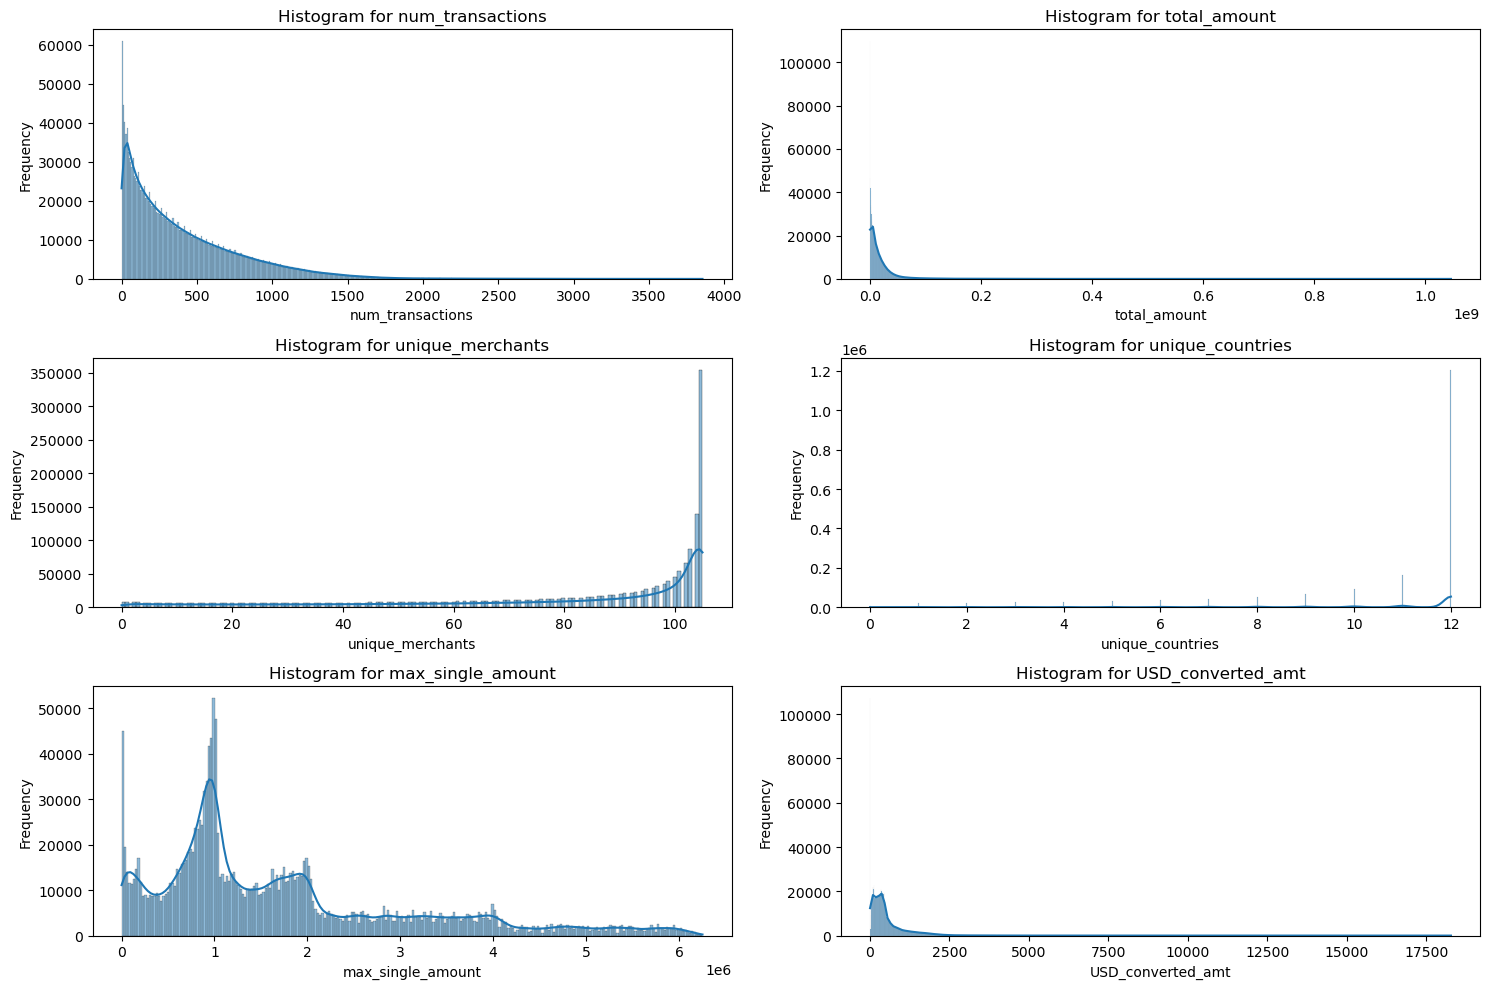

In [35]:
ncol= 2
nrow= -(-len(outlier_check) // ncol)

import seaborn as sns
fig, axes= plt.subplots(nrow, ncol, figsize= (15,10))
axes= axes.flatten()  # flatten for easier indexing
for i, col in enumerate(outlier_check):  # with indexing
    sns.histplot(X_train[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Histogram for {col}')
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

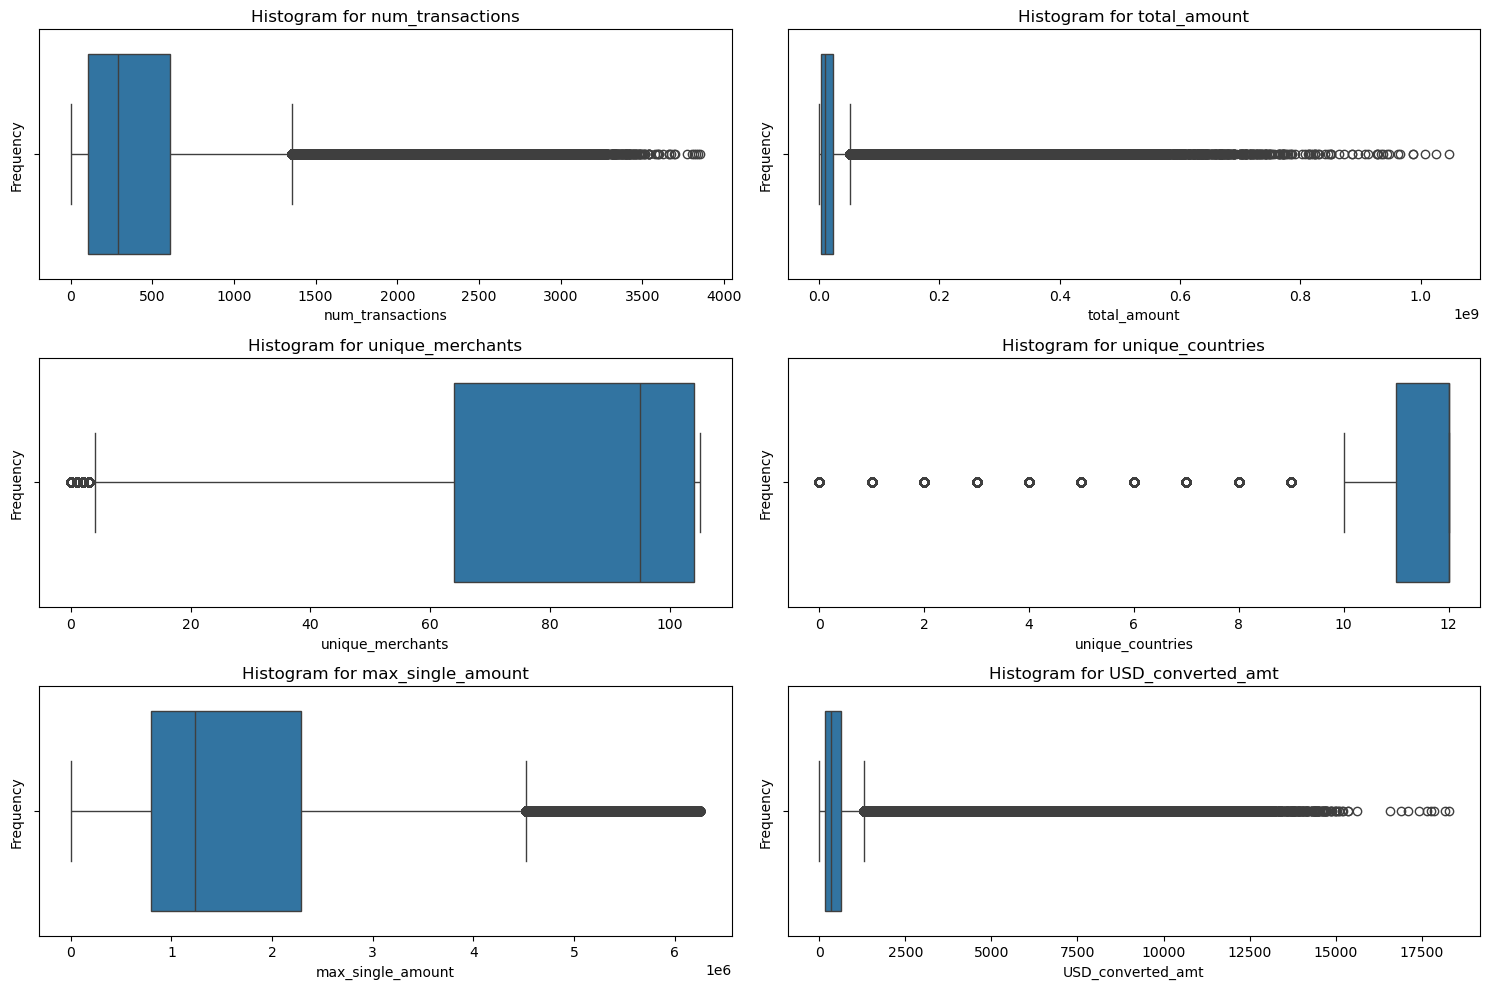

In [36]:
fig, axes= plt.subplots(nrow, ncol, figsize= (15,10))
axes= axes.flatten()  # flatten for easier indexing
for i, col in enumerate(outlier_check):  # with indexing
    sns.boxplot(data=X_train, x=col, ax=axes[i])
    axes[i].set_title(f'Histogram for {col}')
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

none of the above graphs seems to be normally distributed. 
- Thus Standard Scaler is not suitable

Check min and max values

- If the max value is significantly higher than Q3 → Possible high outlier
- If the min value is significantly lower than Q1 → Possible low outlier

In [37]:
X_train[outlier_check].describe()

,num_transactions,total_amount,unique_merchants,unique_countries,max_single_amount,USD_converted_amt
count,1796104.00,1796104.00,1796104.00,1796104.00,1796104.00,1796104.00
mean,409.25,19946055.91,80.04,10.66,1725602.21,538.18
std,391.45,35720354.19,30.46,2.62,1397090.99,718.99
min,0.00,0.01,0.00,0.00,0.01,0.00
25%,106.00,3374442.94,64.00,11.00,801677.94,166.35
50%,292.00,10169199.00,95.00,12.00,1234099.86,353.85
75%,606.00,22740566.27,104.00,12.00,2290390.07,619.98
max,3854.00,1046461946.34,105.00,12.00,6253152.62,18277.24


In [38]:
def check_outliers(df, cols_to_check):
    for col in cols_to_check:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        
        outlier_count = len(df[(df[col] > upper) | (df[col] < lower)])
        print(f'Outlier Count for {col} : {outlier_count}')

In [39]:
check_outliers(X_train, outlier_check)

Outlier Count for num_transactions : 49282
Outlier Count for total_amount : 133130
Outlier Count for unique_merchants : 29704
Outlier Count for unique_countries : 333368
Outlier Count for max_single_amount : 110319
Outlier Count for USD_converted_amt : 169206


Since there are many outliers best to use robust scaling or remove outliers and use minmax scaling

removing outliers would not affect the prediction by a lot. Nevertheless, taking the result of histogram also into apart, the data should rather go through MinMaxScaler to reduce the impact of outliers

In [40]:
# removing outliers 
Q1= X_train[outlier_check].quantile(0.25)
Q3= X_train[outlier_check].quantile(0.75)
IQR= Q3 - Q1

# Define lower and upper bounds
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Create a boolean mask for rows to keep
mask= ~((X_train[outlier_check] < lower) | (X_train[outlier_check] > upper)).any(axis=1)

X_train_clean= X_train[mask]
y_train_clean= y_train[mask]

In [41]:
X_train.shape, X_train_clean.shape

((1796104, 24), (1113990, 24))

In [42]:
check_outliers(X_train_clean, outlier_check)

Outlier Count for num_transactions : 17756
Outlier Count for total_amount : 29988
Outlier Count for unique_merchants : 34191
Outlier Count for unique_countries : 224063
Outlier Count for max_single_amount : 59637
Outlier Count for USD_converted_amt : 56722


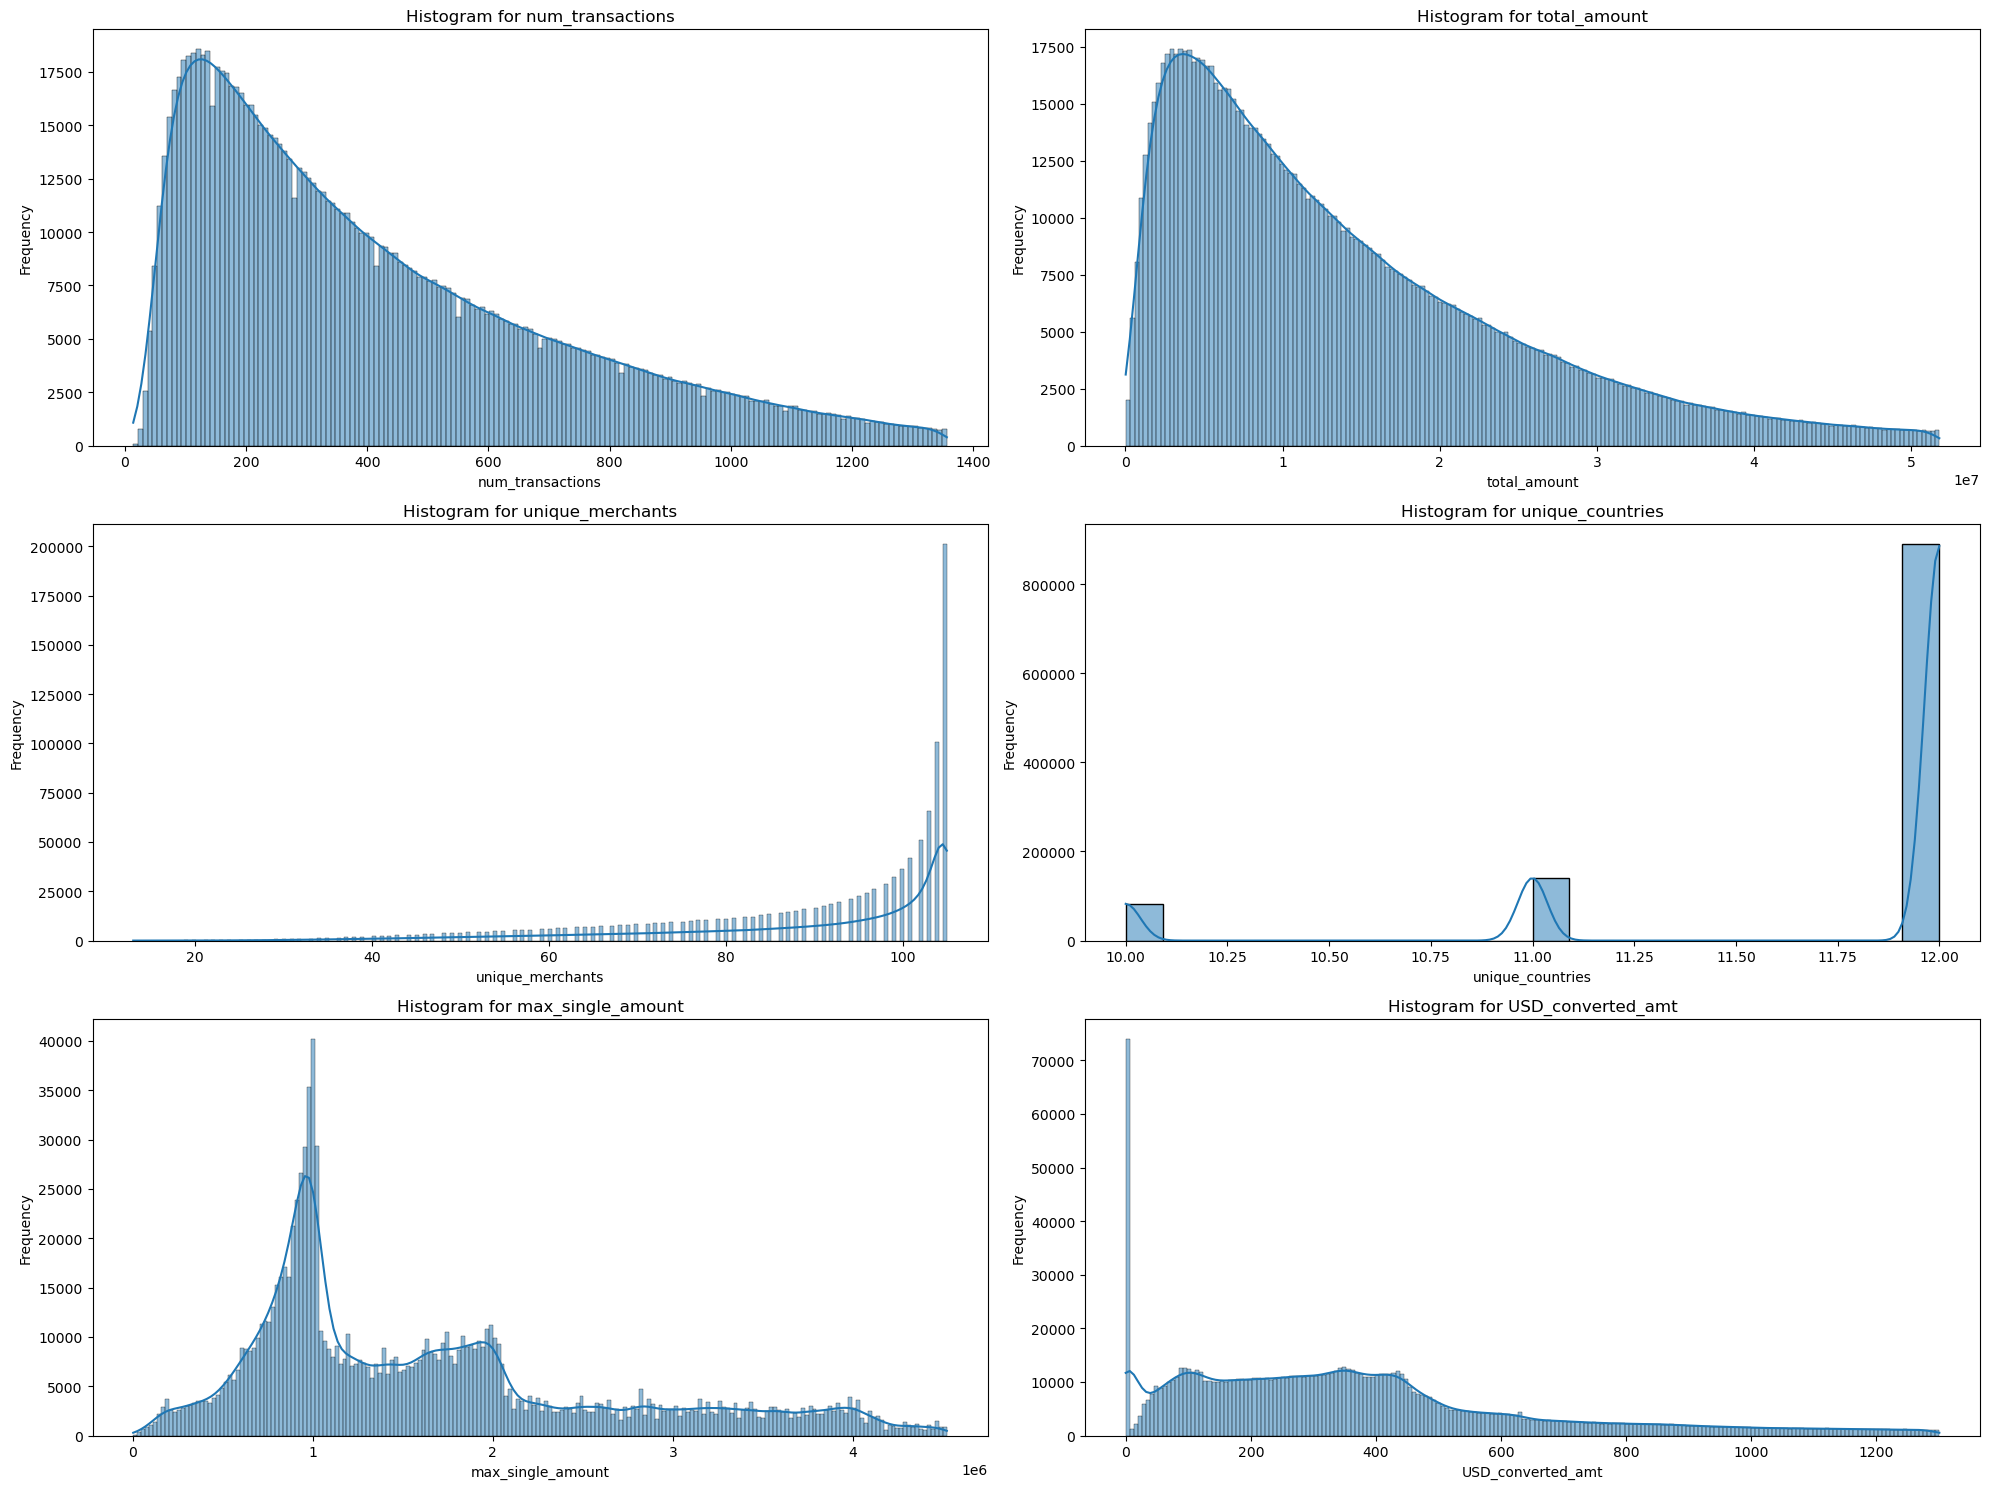

In [43]:
fig, axes= plt.subplots(nrow, ncol, figsize= (20,15))
axes= axes.flatten()  # flatten for easier indexing
for i, col in enumerate(outlier_check):  # with indexing
    sns.histplot(X_train_clean[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Histogram for {col}')
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

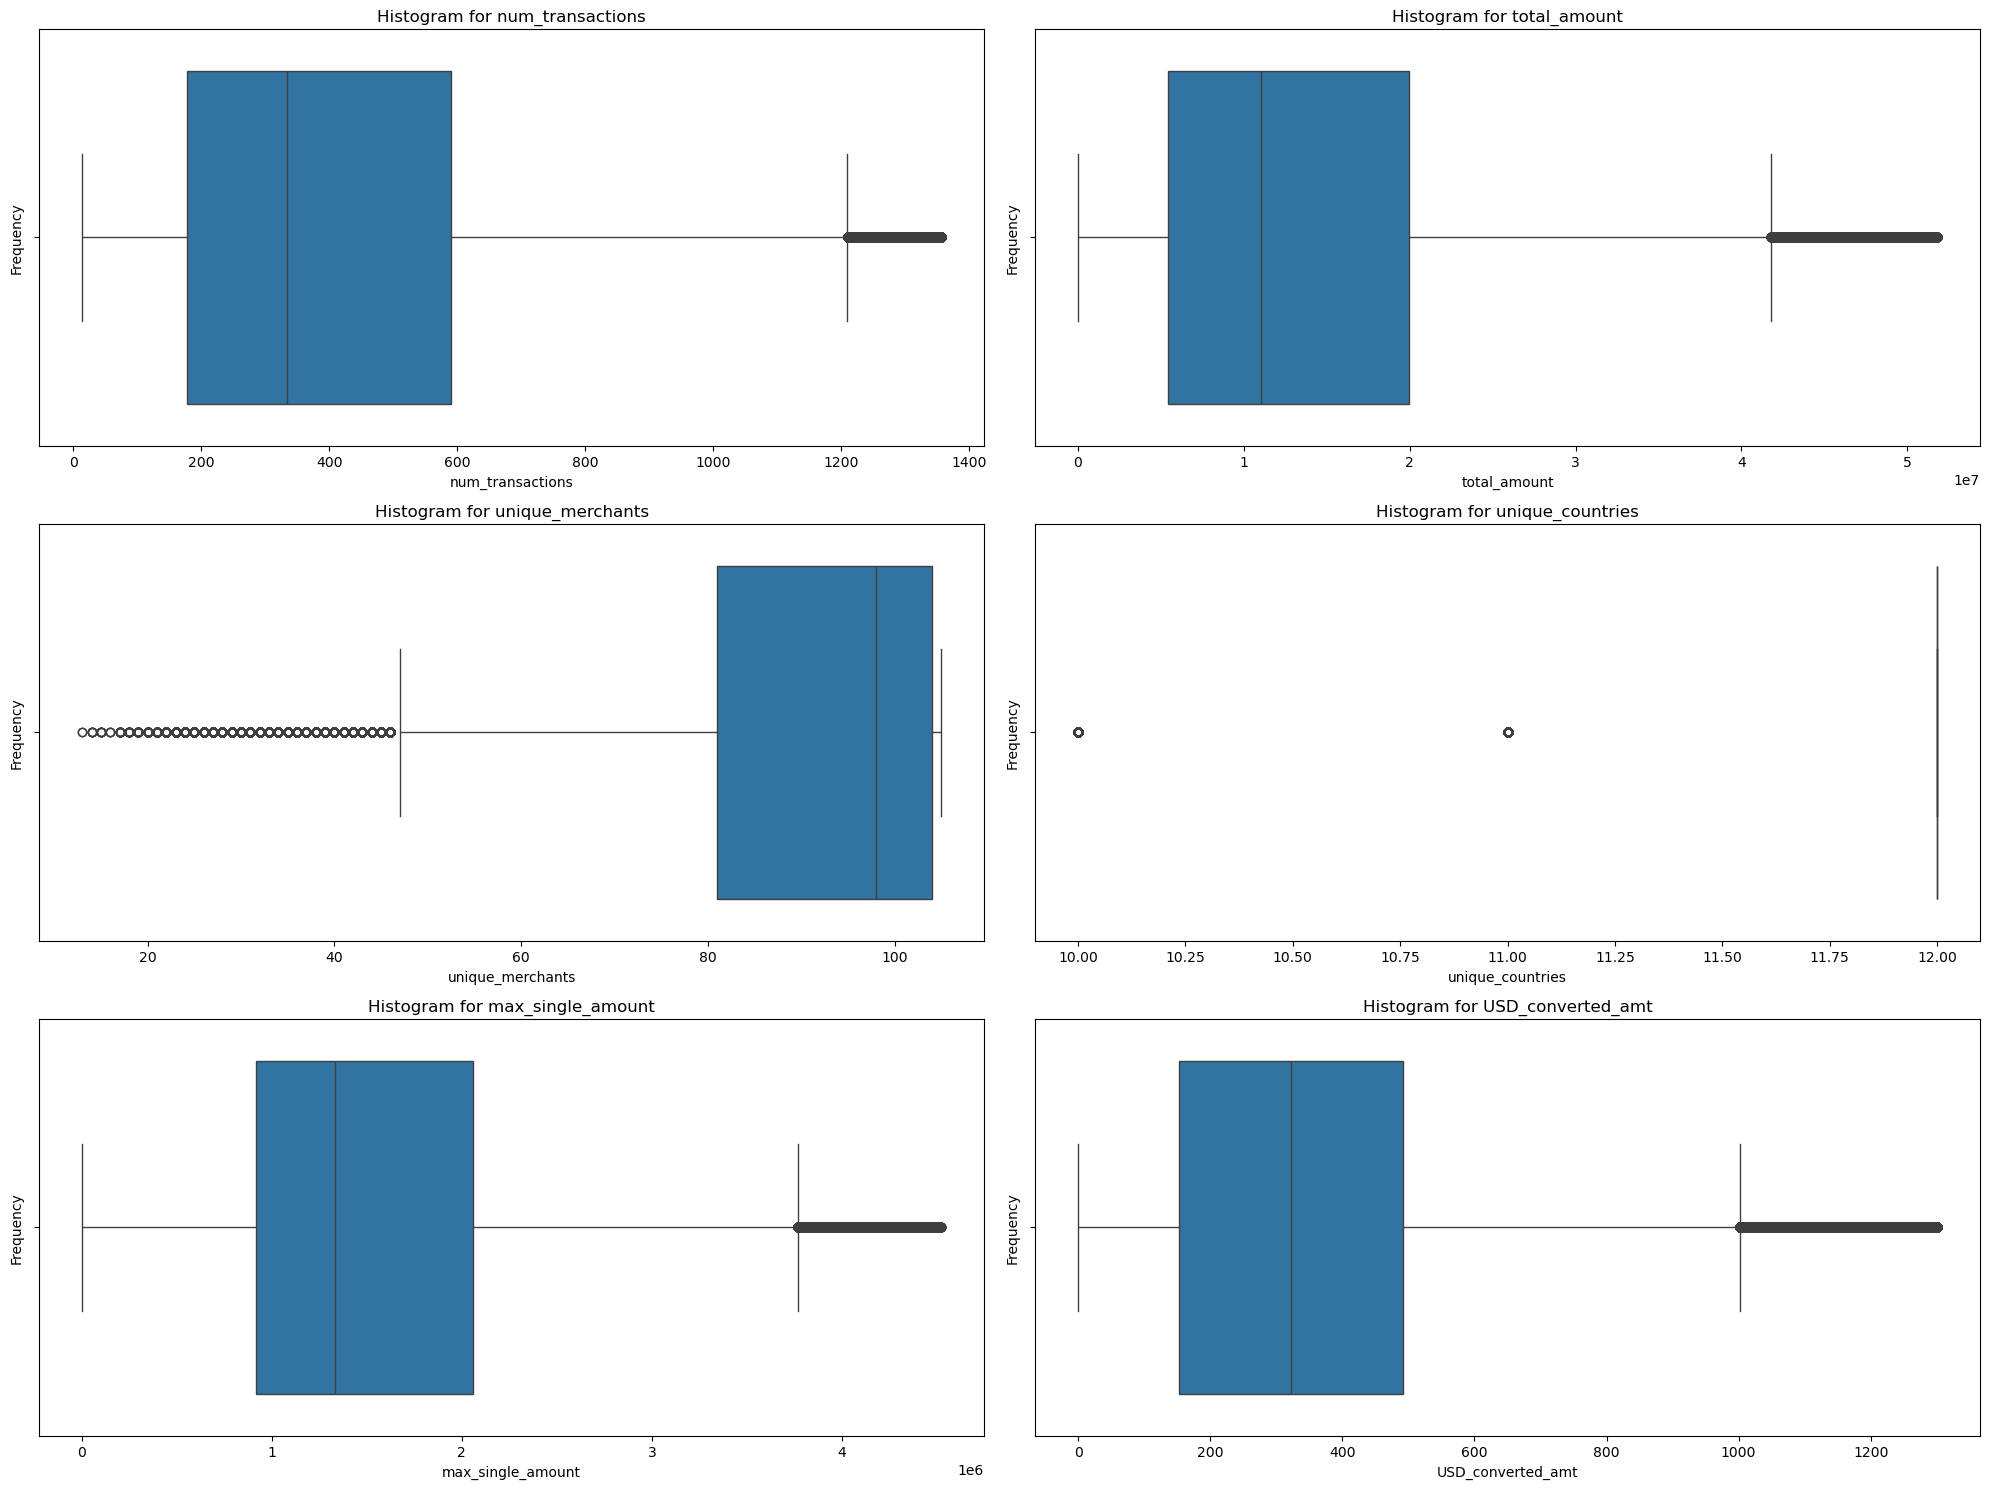

In [44]:
fig, axes= plt.subplots(nrow, ncol, figsize= (20,15))
axes= axes.flatten()  # flatten for easier indexing
for i, col in enumerate(outlier_check):  # with indexing
    sns.boxplot(data=X_train_clean, x=col, ax=axes[i])
    axes[i].set_title(f'Histogram for {col}')
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [45]:
X_train= X_train_clean
y_train= y_train_clean

#### feature encoding

In [46]:
col_to_scale = freq_enc + time_cols + outlier_check
col_to_scale

['merchant_type',
 'merchant',
 'country',
 'city',
 'year',
 'month',
 'day',
 'hour',
 'minute',
 'num_transactions',
 'total_amount',
 'unique_merchants',
 'unique_countries',
 'max_single_amount',
 'USD_converted_amt']

In [47]:
ct= ColumnTransformer(transformers=[
    ('one-hot', OneHotEncoder(), one_enc),
    ('ordinal', OrdinalEncoder(categories= [['medium', 'large']]), ord_enc)
], remainder='passthrough')

# data contains outlier
# rb= RobustScaler()
ms= MinMaxScaler()

# standardarize 
X_train[col_to_scale]= ms.fit_transform(X_train[col_to_scale])  # only numeric and frequency encoded columns only 
X_test[col_to_scale]= ms.transform(X_test[col_to_scale])

# encode features
X_train_enc= ct.fit_transform(X_train)
X_test_enc= ct.transform(X_test)

# encode label 
# y_train_enc= le.fit_transform(y_train)  no need already converted to 0/1
# y_test_enc= le.transform(y_test)


#### get feature names

In [48]:
# Get feature names after transformation
feature_names = (ct.named_transformers_['one-hot'].get_feature_names_out(one_enc).tolist() + 
                ['city_size'] + 
                [col for col in X.columns if col not in one_enc + ord_enc])

X_train_enc= pd.DataFrame(data=X_train_enc, columns=feature_names)
X_test_enc= pd.DataFrame(data=X_test_enc, columns=feature_names)

#### Build a model

In [49]:
model= LogisticRegression()
model.fit(X_train_enc, y_train)
model.score(X_train_enc, y_train), model.score(X_test_enc, y_test)

(0.9329329706729863, 0.9248105900326484)

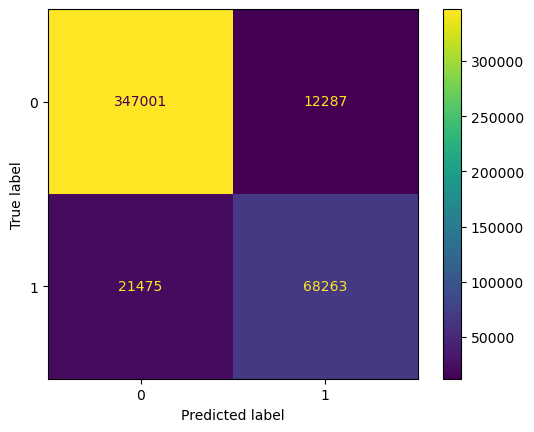

In [50]:
y_pred= model.predict(X_test_enc)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred)).plot()

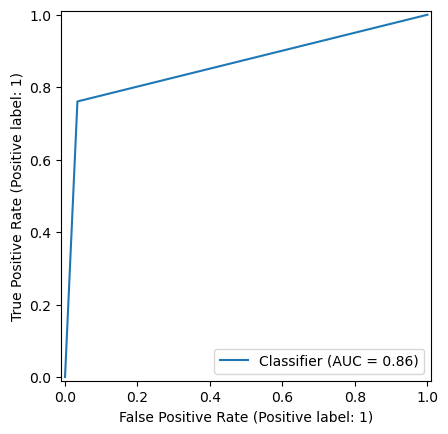

In [51]:
RocCurveDisplay.from_predictions(y_test, y_pred)

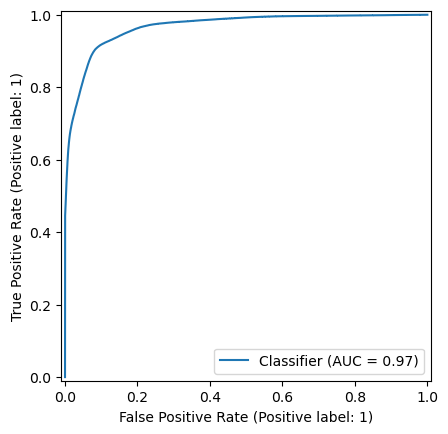

In [52]:
RocCurveDisplay.from_predictions(y_test, model.predict_proba(X_test_enc)[:,1])      # with respect to tpr (true positive)/ fraud

In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95    359288
           1       0.85      0.76      0.80     89738

    accuracy                           0.92    449026
   macro avg       0.89      0.86      0.88    449026
weighted avg       0.92      0.92      0.92    449026



##### traing model with balanced model
- using class_weights='balance' as hyperparameter ()
- using RandomOverSample (duplicates the minority class)
- SMOTE (Synthetic Minority Over-sampling Technique) - generating synthetic samples of the minority class, thus balancing the dataset and potentially improving model performance. 

In [54]:
model_2= LogisticRegression(class_weight='balanced')
model_2.fit(X_train_enc, y_train)
model_2.score(X_train_enc, y_train), model_2.score(X_test_enc, y_test)

(0.9109426476000683, 0.9064731218236806)

In [55]:
print(classification_report(y_test, model.predict(X_test_enc))), print(classification_report(y_test, model_2.predict(X_test_enc)))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95    359288
           1       0.85      0.76      0.80     89738

    accuracy                           0.92    449026
   macro avg       0.89      0.86      0.88    449026
weighted avg       0.92      0.92      0.92    449026

              precision    recall  f1-score   support

           0       0.98      0.90      0.94    359288
           1       0.71      0.91      0.80     89738

    accuracy                           0.91    449026
   macro avg       0.84      0.91      0.87    449026
weighted avg       0.92      0.91      0.91    449026



(None, None)

(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x203f37bffe0>,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x203f37e3bc0>)

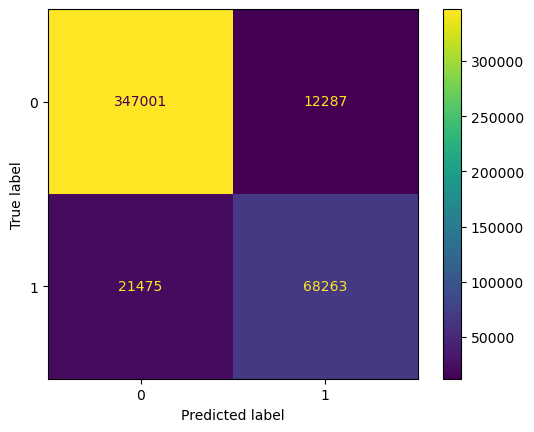

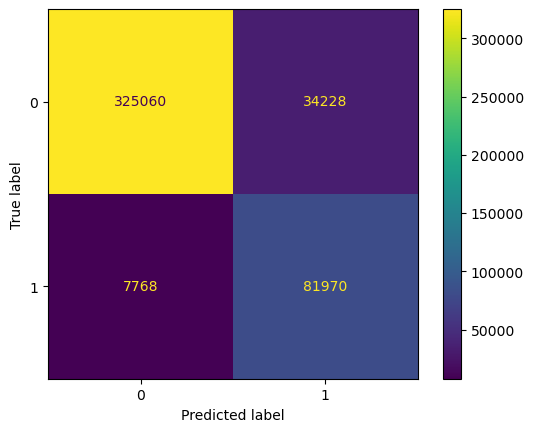

In [56]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, model.predict(X_test_enc))).plot(), ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, model_2.predict(X_test_enc))).plot()

##### Random Over Sample

In [57]:
ros= RandomOverSampler()
bal_X_train_enc, bal_y_train=  ros.fit_resample(X_train_enc, y_train)

print(f'Percentage of Fraudulent Transaction : {bal_y_train.value_counts(normalize = True)[0] * 100}%')
print(f'Percentage of Normal Transaction : {bal_y_train.value_counts(normalize = True)[1] * 100}%')

Percentage of Fraudulent Transaction : 50.0%
Percentage of Normal Transaction : 50.0%


In [58]:
bal_model= LogisticRegression()
bal_model.fit(bal_X_train_enc, bal_y_train)
bal_model.score(bal_X_train_enc, bal_y_train), bal_model.score(X_test_enc, y_test)

(0.9144581252340948, 0.9067425939700596)

In [59]:
print(classification_report(y_test, model.predict(X_test_enc)))
print(classification_report(y_test, bal_model.predict(X_test_enc)))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95    359288
           1       0.85      0.76      0.80     89738

    accuracy                           0.92    449026
   macro avg       0.89      0.86      0.88    449026
weighted avg       0.92      0.92      0.92    449026

              precision    recall  f1-score   support

           0       0.98      0.91      0.94    359288
           1       0.71      0.91      0.80     89738

    accuracy                           0.91    449026
   macro avg       0.84      0.91      0.87    449026
weighted avg       0.92      0.91      0.91    449026



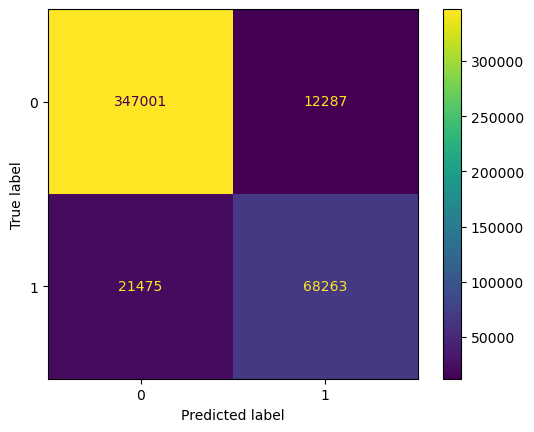

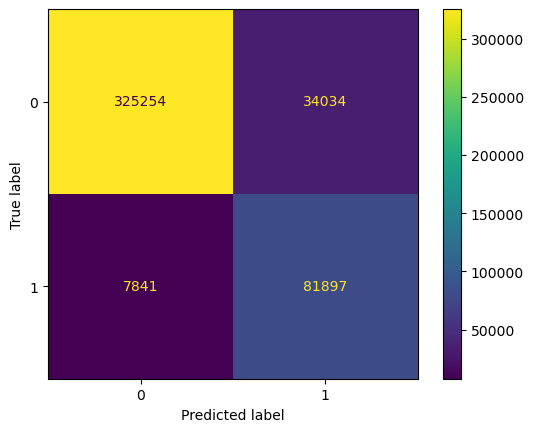

In [60]:
ConfusionMatrixDisplay.from_predictions(y_test, model.predict(X_test_enc))
ConfusionMatrixDisplay.from_predictions(y_test, bal_model.predict(X_test_enc))

In [61]:
bal_model.score(X_train_enc, y_train), bal_model.score(X_test_enc, y_test)

(0.9110844801120297, 0.9067425939700596)

<Axes: >

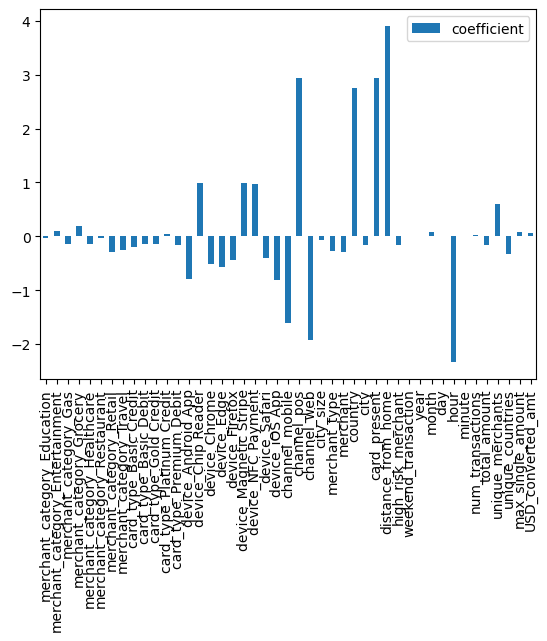

In [62]:
pd.DataFrame({'coefficient': bal_model.coef_[0]}, index=feature_names).plot.bar()

<Axes: >

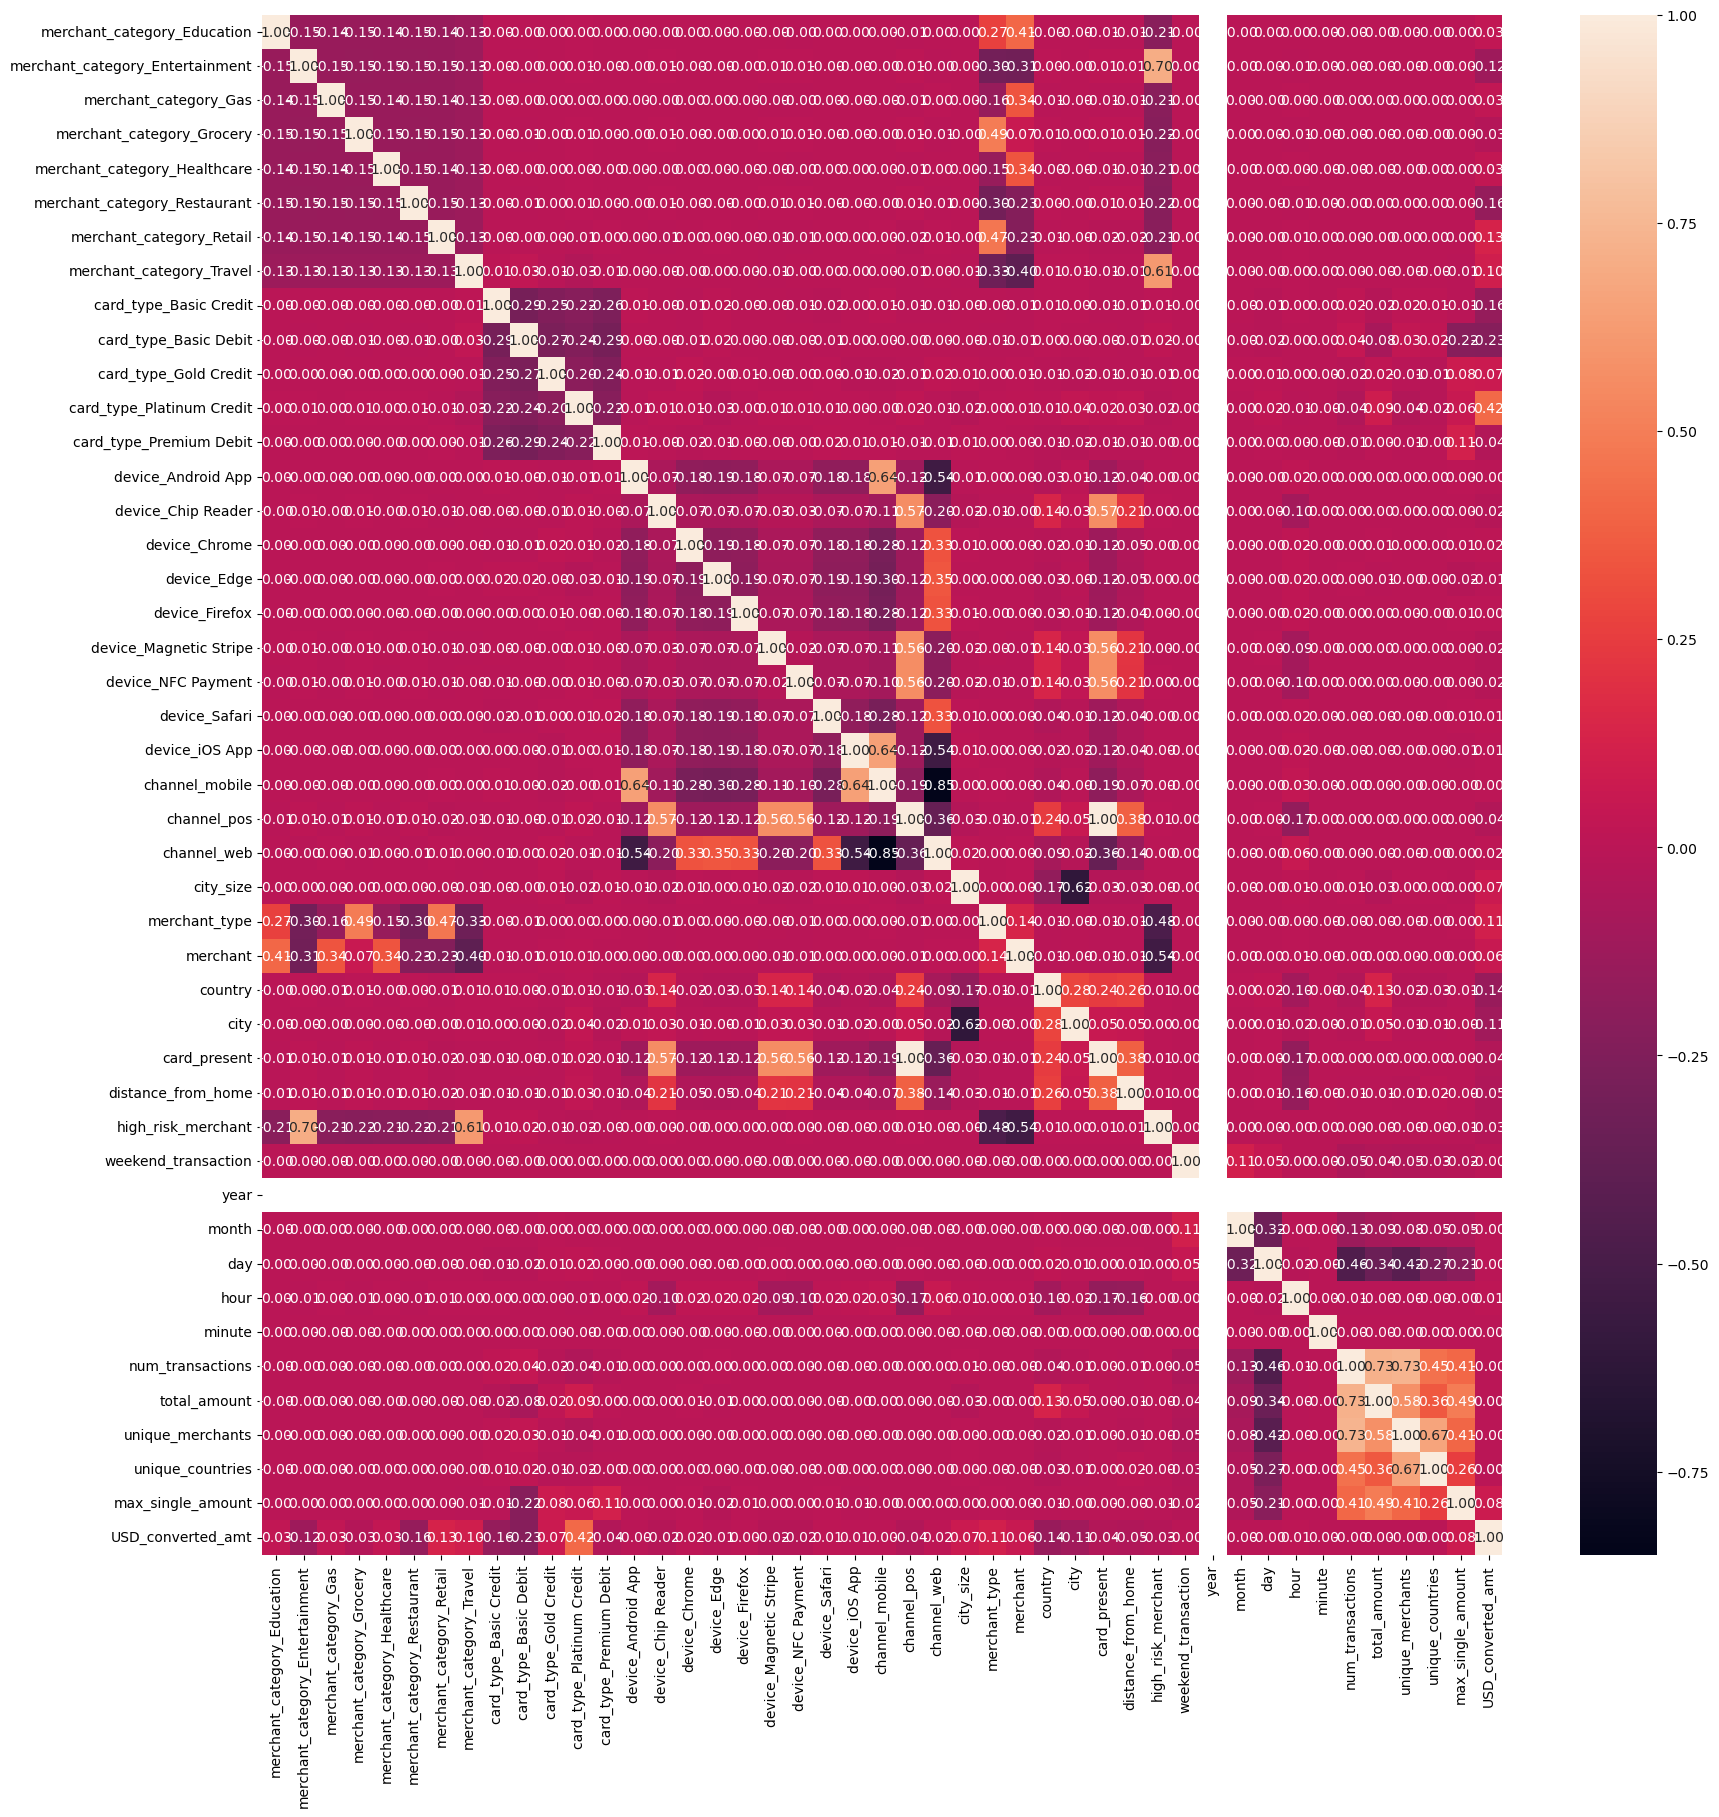

In [63]:
# Visualisation
plt.figure(figsize = (20, 20))
sns.heatmap(X_train_enc.corr(), annot=True, fmt='.2f')

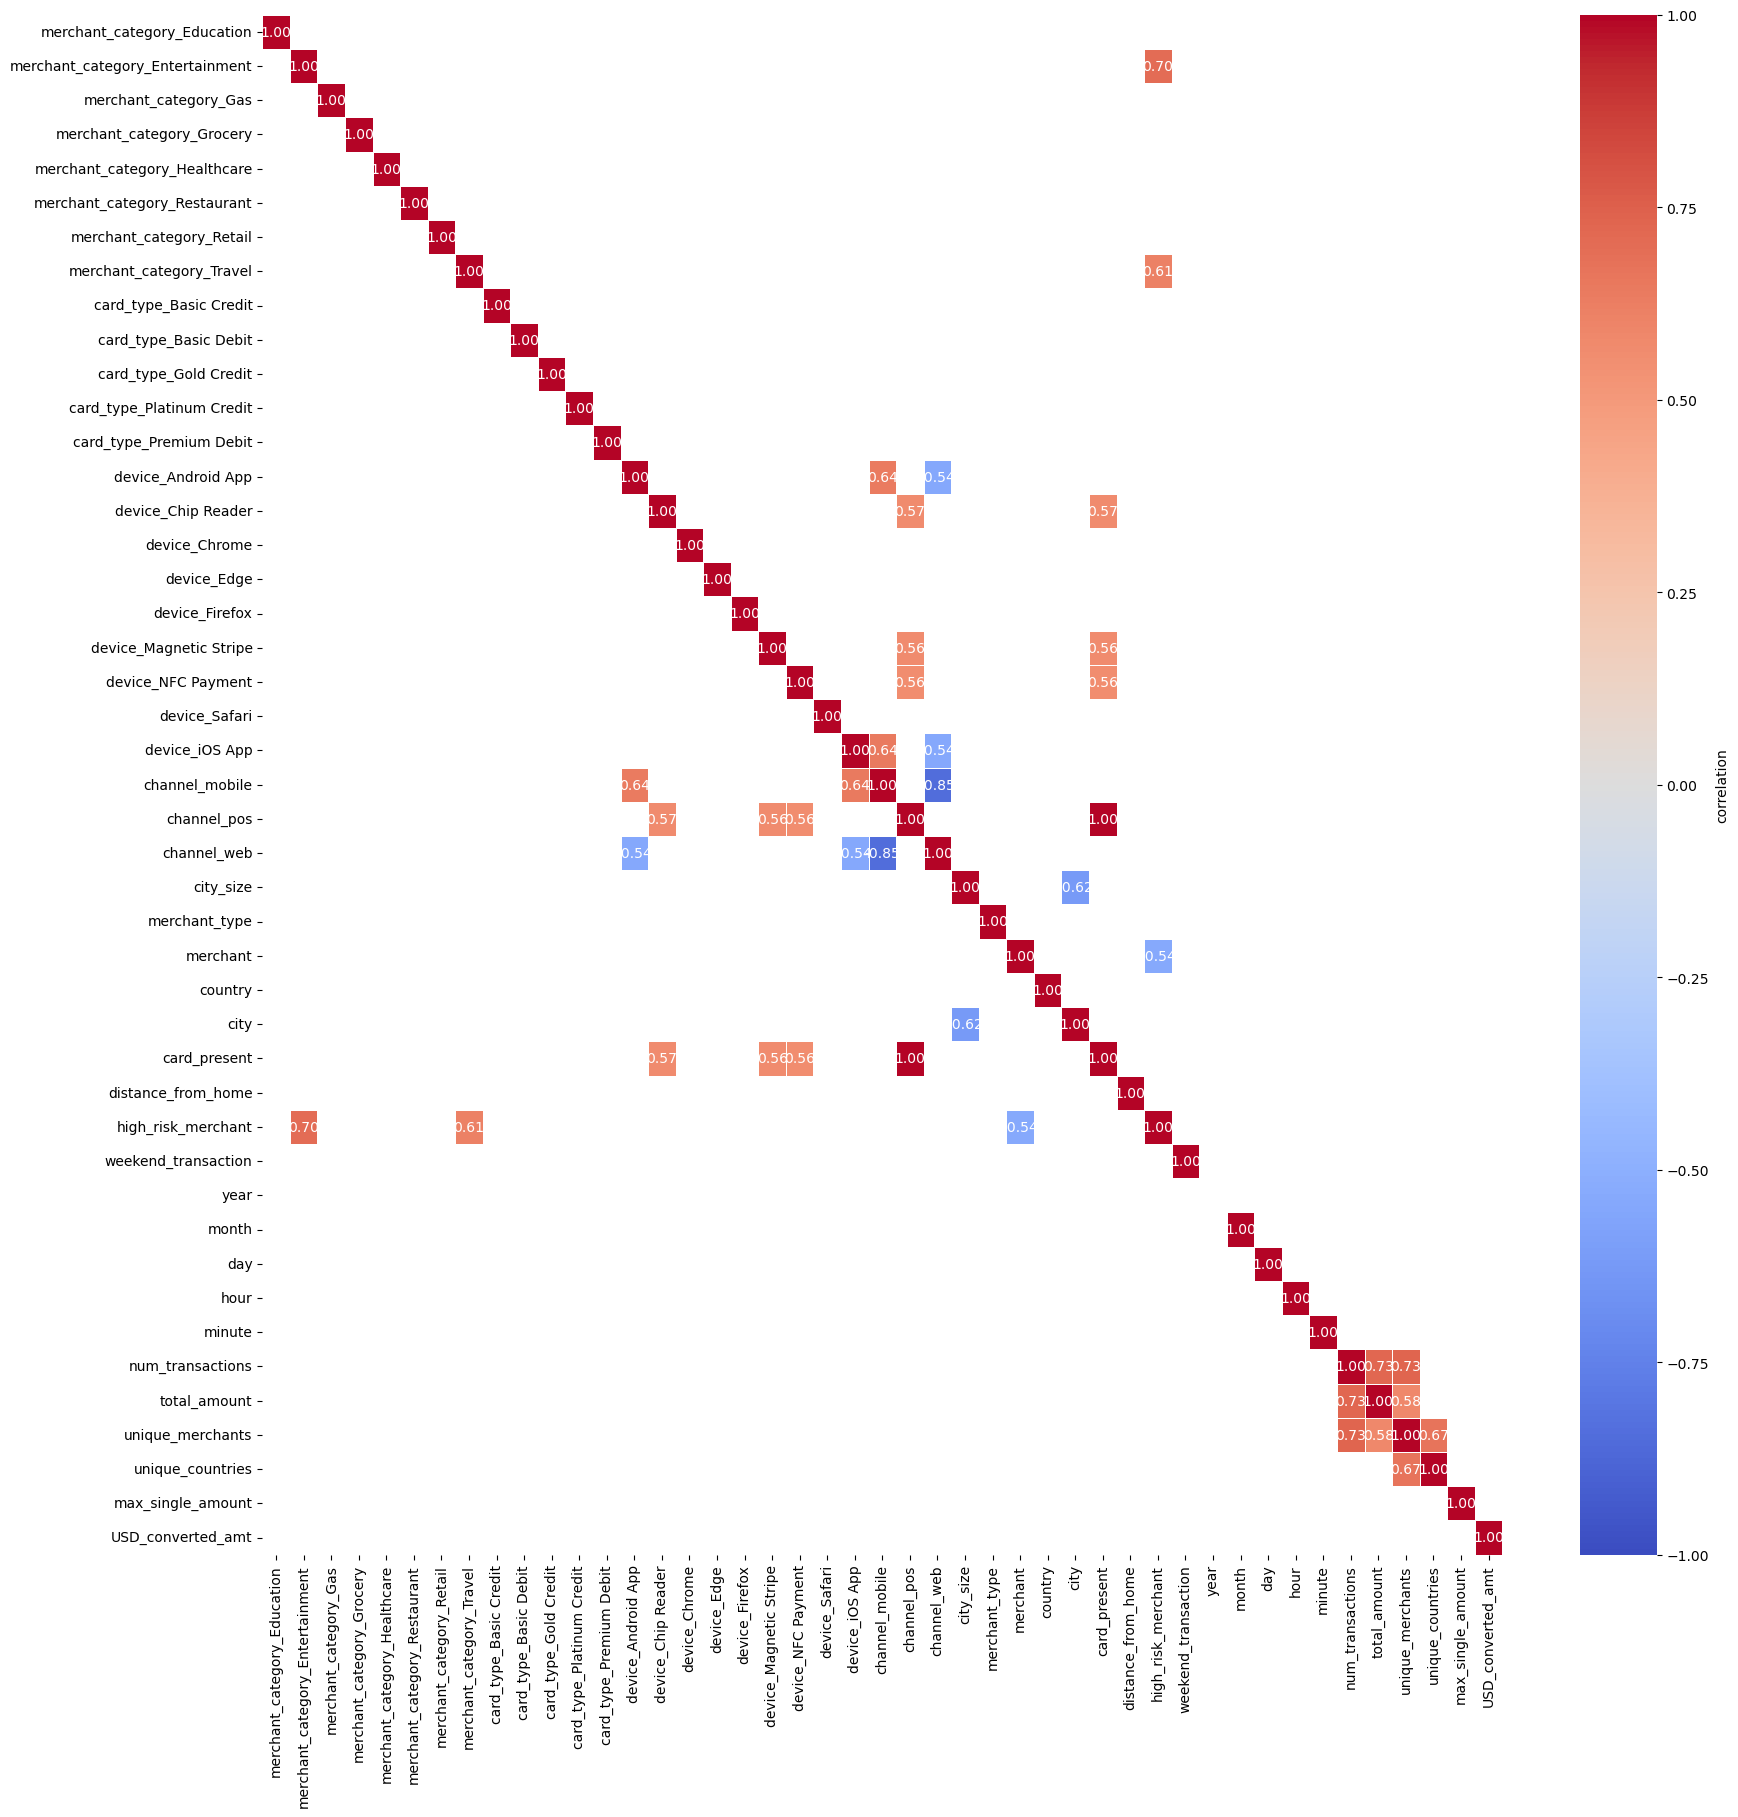

In [64]:
## Heatmap Creation to perform multivariate analysis
transaction_corr = X_train_enc.corr()

# Set up a threshold to limit uncorrelated values to be visible
threshold = 0.5

# Filter the possible correlations
filtered_corr = transaction_corr[abs(transaction_corr) >= 0.5]

# Visualisation
plt.figure(figsize = (20, 20))
sns.heatmap(filtered_corr, vmin = -1, vmax = 1, annot = True, fmt = '.2f', linewidth = 0.5, mask = filtered_corr.isnull(), 
           cmap = 'coolwarm', cbar_kws = {'label' : 'correlation'})
plt.show()

#### Feature Importance

<Axes: >

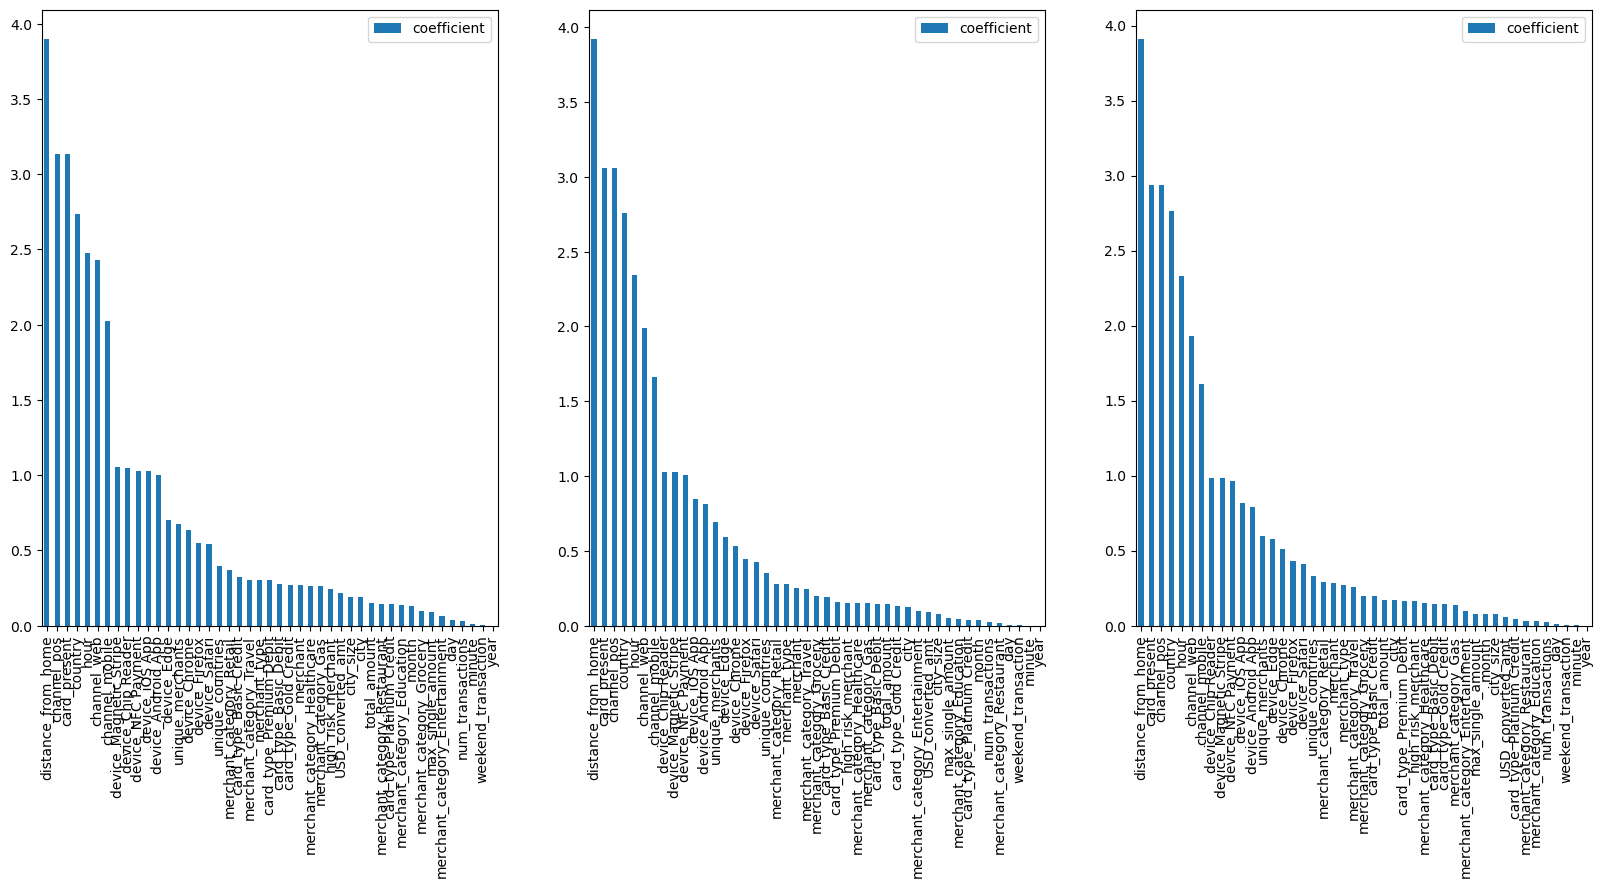

In [65]:
fig, axes= plt.subplots(1,3, figsize=(20,8))
pd.DataFrame({'coefficient': model.coef_[0]}, index=feature_names).abs().sort_values('coefficient', ascending=False).plot.bar(ax=axes[0]),
pd.DataFrame({'coefficient': model_2.coef_[0]}, index=feature_names).abs().sort_values('coefficient', ascending=False).plot.bar(ax= axes[1]),
pd.DataFrame({'coefficient': bal_model.coef_[0]}, index=feature_names).abs().sort_values('coefficient', ascending=False).plot.bar(ax= axes[2])

##### random forest

In [66]:
ran_model = RandomForestClassifier(n_jobs= -1, n_estimators= 50,
                                   max_depth=20,
                                   min_samples_split=10,
                                   min_samples_leaf= 20,
                                   max_features= 'sqrt')

ran_model.fit(bal_X_train_enc, bal_y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=20, min_samples_split=10,
                       n_estimators=50, n_jobs=-1)

In [67]:
ran_model.score(bal_X_train_enc, bal_y_train), ran_model.score(X_test_enc, y_test), ran_model.score(X_train_enc, y_train)

(0.9704239125859068, 0.9620356059560026, 0.969927916767655)

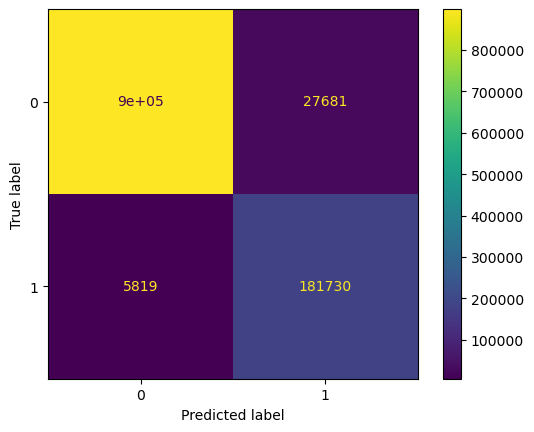

In [68]:
ConfusionMatrixDisplay(confusion_matrix(y_train, ran_model.predict(X_train_enc))).plot()

In [69]:
print(classification_report(y_test, ran_model.predict(X_test_enc)))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    359288
           1       0.88      0.94      0.91     89738

    accuracy                           0.96    449026
   macro avg       0.93      0.95      0.94    449026
weighted avg       0.96      0.96      0.96    449026



#### compare model

In [70]:
def evaluate_model(y_true, y_preds):
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    metric_dict = {
        'accuracy': round(accuracy, 2),
        'precision': round(precision, 2),
        'recall': round(recall, 2),
        'precision': round(precision, 2),
        'f1': round(f1, 2)
    }    
    # print(f'Acc: {accuracy*100:.2f}%')
    # print(f'Precision: {precision:.2f}')
    # print(f'Recall: {recall:.2f}')
    # print(f'F1 score: {f1:.2f}')

    return metric_dict

Text(0.5, 1.0, 'Model Evaluation Metrics')

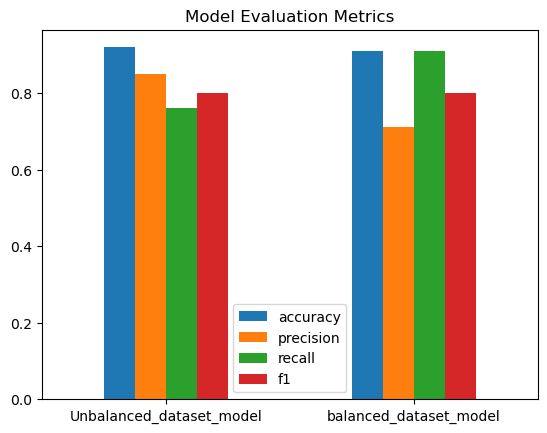

In [71]:
model_preds = model.predict(X_test_enc)
bal_model_preds = model_2.predict(X_test_enc)
model_metric = evaluate_model(y_test, model_preds)
bal_model_metric = evaluate_model(y_test, bal_model_preds)

compare_metric = pd.DataFrame({'Unbalanced_dataset_model': model_metric,
                              'balanced_dataset_model':bal_model_metric})

compare_metric.T.plot.bar()
plt.xticks(rotation=0)
plt.title('Model Evaluation Metrics')

In [72]:
model_preds = model.predict(X_test_enc)
model_metric = evaluate_model(y_test, model_preds)
test_compare_metric = pd.DataFrame(data=[model_metric], index= ['unbalanced logistic'])

model_preds = model_2.predict(X_test_enc)
model_metric = evaluate_model(y_test, model_preds)
test_compare_metric.loc['bal weights logistic'] =  model_metric

model_preds = bal_model.predict(X_test_enc)
model_metric = evaluate_model(y_test, model_preds)
test_compare_metric.loc['ROS logistic'] =  model_metric

model_preds = ran_model.predict(X_test_enc)
model_metric = evaluate_model(y_test, model_preds)
test_compare_metric.loc['ROS random forest'] =  model_metric

test_compare_metric

,accuracy,precision,recall,f1
unbalanced logistic,0.92,0.85,0.76,0.80
bal weights logistic,0.91,0.71,0.91,0.80
ROS logistic,0.91,0.71,0.91,0.80
ROS random forest,0.96,0.88,0.94,0.91


In [73]:
model_preds = model.predict(X_train_enc)
model_metric = evaluate_model(y_train, model_preds)
train_compare_metric = pd.DataFrame(data=[model_metric], index= ['unbalanced logistic'])

model_preds = model_2.predict(X_train_enc)
model_metric = evaluate_model(y_train, model_preds)
train_compare_metric.loc['bal weights logistic'] =  model_metric

model_preds = bal_model.predict(X_train_enc)
model_metric = evaluate_model(y_train, model_preds)
train_compare_metric.loc['ROS logistic'] =  model_metric

model_preds = ran_model.predict(X_train_enc)
model_metric = evaluate_model(y_train, model_preds)
train_compare_metric.loc['ROS random forest'] =  model_metric

train_compare_metric

,accuracy,precision,recall,f1
unbalanced logistic,0.93,0.83,0.76,0.79
bal weights logistic,0.91,0.67,0.92,0.78
ROS logistic,0.91,0.67,0.92,0.78
ROS random forest,0.97,0.87,0.97,0.92


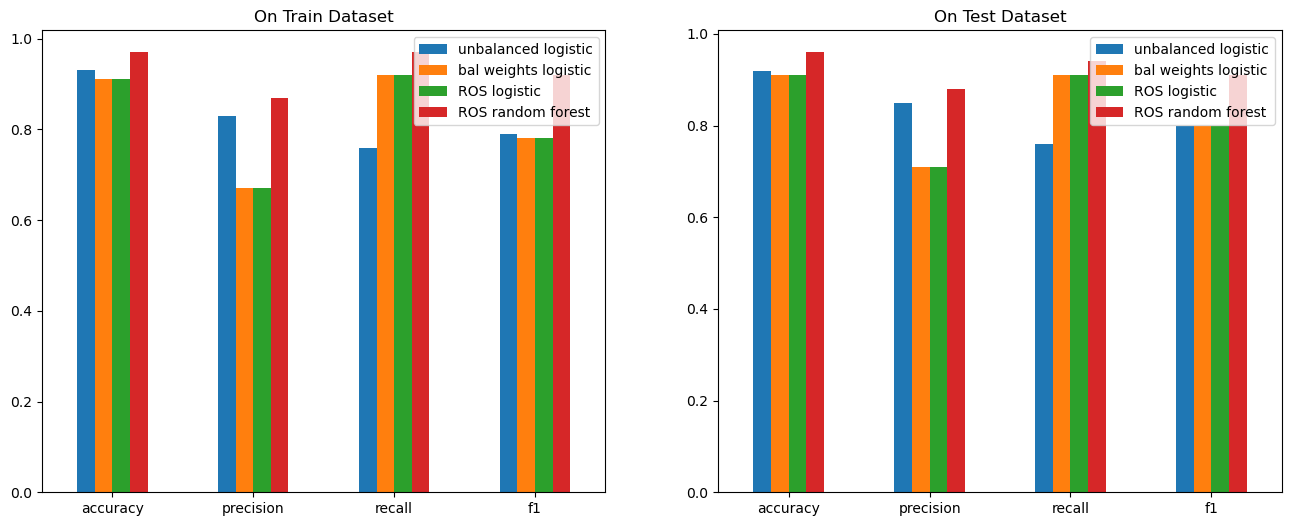

In [74]:
fig, axes= plt.subplots(1,2, figsize=(16,6))

train_compare_metric.T.plot.bar(ax= axes[0], title='On Train Dataset')
axes[0].set_xticklabels(test_compare_metric.T.index, rotation=0)

test_compare_metric.T.plot.bar(ax= axes[1], title='On Test Dataset')
axes[1].set_xticklabels(test_compare_metric.T.index, rotation=0)
plt.show()

In [75]:
pd.concat([train_compare_metric, test_compare_metric], axis=1)

,accuracy,precision,recall,f1,accuracy,precision,recall,f1
unbalanced logistic,0.93,0.83,0.76,0.79,0.92,0.85,0.76,0.80
bal weights logistic,0.91,0.67,0.92,0.78,0.91,0.71,0.91,0.80
ROS logistic,0.91,0.67,0.92,0.78,0.91,0.71,0.91,0.80
ROS random forest,0.97,0.87,0.97,0.92,0.96,0.88,0.94,0.91


##### roc comparism

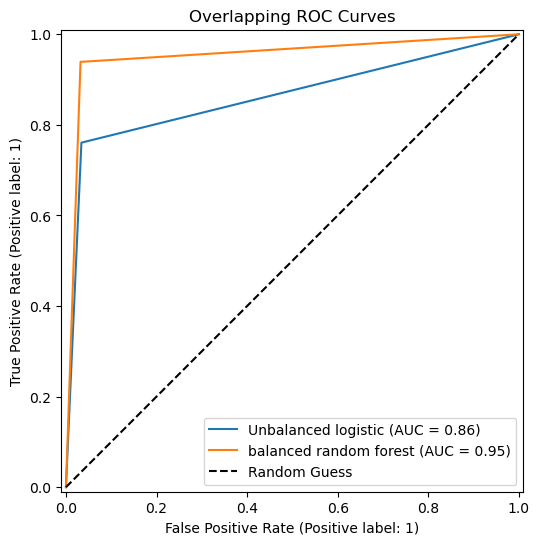

In [76]:
plt.figure(figsize=(8, 6))

# Plot ROC curve for Model 1
RocCurveDisplay.from_predictions(
    y_test, model.predict(X_test_enc), name='Unbalanced logistic', ax=plt.gca()
)

# Plot ROC curve for Model 2
RocCurveDisplay.from_predictions(
    y_test, ran_model.predict(X_test_enc), name='balanced random forest', ax=plt.gca()
)

# Add a diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Add title and legend
plt.title('Overlapping ROC Curves')
plt.legend(loc='lower right')
plt.show()


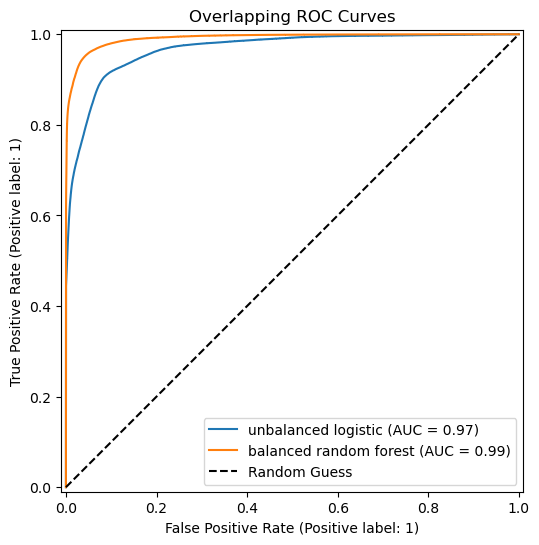

In [77]:
plt.figure(figsize=(8, 6))

# Plot ROC curve for Model 1
RocCurveDisplay.from_predictions(
    y_test, model.predict_proba(X_test_enc)[:,1], name='unbalanced logistic', ax=plt.gca()
)

# Plot ROC curve for Model 2
RocCurveDisplay.from_predictions(
    y_test, ran_model.predict_proba(X_test_enc)[:,1], name='balanced random forest', ax=plt.gca()
)

# Add a diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Add title and legend
plt.title('Overlapping ROC Curves')
plt.legend(loc='lower right')
plt.show()


### 🎯 Choosing the Right Model  
In fraud transaction detection, our priority is to have **higher recall** (lower FN) – catching all fraud (+ve) cases.  

#### ✅ Best Choice:  
- **🚀 ROS Random Forest**  
  - 📈 **Highest test accuracy** (0.96) and **precision** (0.88).  
  - ⚖️ **High F1-score** (0.91), indicating strong overall performance.  
  - ✅ **Highest recall** (0.94) among the models, making it the most reliable choice for fraud detection.  

- **⚖️ Unbalanced Logistic Regression (if precision is a priority)**  
  - 🔼 **Good precision** (0.85), but lower recall (0.76).  
  - 📉 **Slightly lower test accuracy** (0.92) compared to ROS Random Forest (0.96).  
  - 📊 **Moderate F1-score** (0.80), making it useful when reducing false positives is more important.  

#### ⚠️ Why is Recall Most Critical for Fraud Detection?  
✔️ **High Recall** ensures most fraudulent transactions are caught (minimizing false negatives).  
✔️ **Precision is secondary** since false positives (flagging a legit transaction as fraud) are more tolerable than missing a fraud case.  
✔️ **F1-score matters** as it balances precision and recall.  

---

#### 🔍 ROS Random Forest  
✅ **Highest Recall (0.94)** → Catches 94% of fraud cases.  
✅ **F1-score (0.91)** is strong, balancing precision and recall.  
✅ **Better at detecting fraud** than the Unbalanced Logistic model (which has recall 0.76).  

#### ❌ Why Not Unbalanced Logistic?  
🔻 **Higher precision (0.85) but lower recall (0.76)** → May miss too many fraud cases, which is risky in fraud detection.  

#### ❌ Why Not Balanced Weights Logistic / ROS Logistic?  
⚠️ **Lower recall (0.91)** compared to ROS Random Forest (0.94).  
⚠️ **Lower precision (0.71/0.70)** compared to Unbalanced Logistic (0.85).  
⚠️ **Same F1-score (0.80)** as Unbalanced Logistic but lacks the precision advantage.  

---

#### 🏆 Final Model:  
🔥 **Choose "ROS Random Forest"** for fraud detection because it has the **highest recall (0.94)** and **high precision (0.88)**.  
❌ **Avoid using "Unbalanced Logistic"** if catching all fraud cases is the primary goal.  
❌ **Ignore "Balanced Weights Logistic" and "ROS Logistic"** as they are less effective in recall and precision compared to ROS Random Forest.

#### make predictions

In [78]:
X_test.head(2)

,merchant_category,merchant_type,merchant,country,city,city_size,card_type,card_present,device,channel,...,month,day,hour,minute,num_transactions,total_amount,unique_merchants,unique_countries,max_single_amount,USD_converted_amt
628886,Restaurant,0.07,0.12,0.26,1.00,medium,Platinum Credit,0,Android App,mobile,...,1.00,0.03,0.65,0.12,0.20,0.23,0.88,1.00,0.70,0.51
3017013,Gas,0.20,0.33,0.12,1.00,medium,Premium Debit,0,Chrome,web,...,1.00,0.38,0.52,0.73,0.09,0.06,0.67,0.50,0.19,0.31


In [79]:
X_test_enc.head(2)

,merchant_category_Education,merchant_category_Entertainment,merchant_category_Gas,merchant_category_Grocery,merchant_category_Healthcare,merchant_category_Restaurant,merchant_category_Retail,merchant_category_Travel,card_type_Basic Credit,card_type_Basic Debit,...,month,day,hour,minute,num_transactions,total_amount,unique_merchants,unique_countries,max_single_amount,USD_converted_amt
0,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,...,1.00,0.03,0.65,0.12,0.20,0.23,0.88,1.00,0.70,0.51
1,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,0.38,0.52,0.73,0.09,0.06,0.67,0.50,0.19,0.31


In [80]:
def make_prediction(pred_set_x, model):
    pred_set_x= ct.transform(pred_set_x)
    # pred_set_x= sc.transform(pred_set_x)
    result= model.predict(pd.DataFrame(pred_set_x, columns=X_train_enc.columns))
    return result.astype('bool')
    # for pred in result:    
    #     if pred:
    #         print("Danger")
    #     else:
    #         print('ok ')

make_prediction(X_test[10:20], model_2)

array([False,  True,  True,  True,  True, False, False, False, False,
       False])

In [81]:

make_prediction(X_test[10:20], model)

array([False, False, False, False,  True, False, False, False, False,
       False])

In [82]:
make_prediction(X_test.sample(15), model_2)

array([False, False, False, False, False, False,  True, False, False,
       False, False,  True, False, False,  True])

pred_df= pd.DataFrame([['Healthcare',	3124,	812,	724949.27,	7143,	7143,	47401,	'medium',	'Basic Debit',	False,	'Chrome',	'web',	1,	1,	False,	0,	False]],
                       columns=X_train.columns)
pred_test_test_test_test_test_test_df

make_prediction(pred_df)

In [83]:
import numpy as np
print(np.concatenate((y_test.values.reshape(-1,1), model_2.predict(X_test_enc).reshape(-1,1)) , axis= 1))

[[0 0]
 [0 0]
 [0 0]
 ...
 [0 0]
 [0 0]
 [0 0]]


Make more predictions

#### save the model

as well as encoders

In [84]:
import os

# Ensure the directory exists
os.makedirs("./models/encoders", exist_ok=True)
# dump model
joblib.dump(model, './models/model_2.pkl')

joblib.dump(ct, './models/encoders/col_transformer.pkl')
joblib.dump(ms, './models/encoders/minmax_scaler.pkl')

# save freq_map for frequency encoder
joblib.dump(all_freq_map, './models/encoders/all_freq_map.pkl')

# save features names (during training)
joblib.dump(feature_names, './models/feature_names.pkl')

['./models/feature_names.pkl']